<a href="https://colab.research.google.com/github/akkiaryan/Automation-Builder-/blob/main/MINI_ALADIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHASE 1

In [55]:
# ==================== ONE-CELL FULL PIPELINE (VERSION-PROOF) ====================
# Installs
!pip -q install pandas numpy requests yfinance fredapi tqdm transformers torch scikit-learn xgboost nltk

# ---------------------------- Imports --------------------------------
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning, module=r"torch_xla\..*")

import os, json, time, pathlib
from datetime import datetime, timedelta, timezone
from typing import Dict, Union, Sequence

import pandas as pd
import numpy as np
import requests
import yfinance as yf
from fredapi import Fred
from tqdm import tqdm

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import xgboost as xgb  # use Booster + DMatrix to avoid sklearn API differences

# Sentiment: transformer first, fallback VADER
from transformers import pipeline
import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment import vader

# ---------------------- Config + Keys (Colab-safe) -------------------
try:
    from google.colab import userdata  # type: ignore
except Exception:
    userdata = None

def _get_secret(name: str, alt_names=()):
    if userdata is not None:
        v = userdata.get(name)
        if v: return v
        for alt in alt_names:
            v = userdata.get(alt)
            if v: return v
    v = os.environ.get(name)
    if v: return v
    for alt in alt_names:
        v = os.environ.get(alt)
        if v: return v
    return None

NEWSAPI_KEY = _get_secret("NEWSAPI_KEY")
ALPHA_KEY   = _get_secret("ALPHAVANTAGE_API_KEY", alt_names=("ALPHAVANTAGE",))
FRED_KEY    = _get_secret("FRED_API_KEY")

def _looks_like_real(s: str) -> bool:
    if not s or len(s.strip()) < 8: return False
    for tok in ("YOUR_", "xxxxx", "REPLACE_ME"):
        if tok.lower() in s.lower(): return False
    return True

assert _looks_like_real(NEWSAPI_KEY),  "NEWSAPI_KEY missing. Add in Colab → Secrets."
assert _looks_like_real(ALPHA_KEY),    "ALPHAVANTAGE_API_KEY missing (or name it ALPHAVANTAGE)."
assert _looks_like_real(FRED_KEY),     "FRED_API_KEY missing."

os.environ["NEWSAPI_KEY"] = NEWSAPI_KEY
os.environ["ALPHAVANTAGE_API_KEY"] = ALPHA_KEY
os.environ["FRED_API_KEY"] = FRED_KEY

def utc_now(): return datetime.now(timezone.utc)
print(f"[{utc_now().isoformat()}] ✅ API keys loaded.")

# ------------------------------ Paths --------------------------------
DATA_DIR   = pathlib.Path("/content/data")
RAW_NEWS   = DATA_DIR / "raw" / "news"
RAW_PRICES = DATA_DIR / "raw" / "prices"
PROC_DIR   = DATA_DIR / "processed"
for p in (RAW_NEWS, RAW_PRICES, PROC_DIR): p.mkdir(parents=True, exist_ok=True)

# ------------------------ Universe (tickers) -------------------------
# L&T Finance can be flaky on Yahoo; try both symbols. If both fail, we skip.
TICKERS: Dict[str, Union[str, Sequence[str]]] = {
    "HDFC Bank": "HDFCBANK.NS",
    "ICICI Bank": "ICICIBANK.NS",
    "SBI": "SBIN.NS",
    "Kotak Mah. Bank": "KOTAKBANK.NS",
    "Axis Bank": "AXISBANK.NS",
    "Power Fin.Corpn.": "PFC.NS",
    "Cholaman.Inv.&Fn": "CHOLAFIN.NS",
    "Bank of Baroda": "BANKBARODA.NS",
    "Punjab Natl.Bank": "PNB.NS",
    "Shriram Finance": "SHRIRAMFIN.NS",
    "Union Bank (I)": "UNIONBANK.NS",
    "IDBI Bank": "IDBI.NS",
    "Canara Bank": "CANBK.NS",
    "REC Ltd": "RECLTD.NS",
    "Indian Bank": "INDIANB.NS",
    "I O B": "IOB.NS",
    "Aditya Birla Cap": "ABCAPITAL.NS",
    "Yes Bank": "YESBANK.NS",
    "Bank of India": "BANKINDIA.NS",
    "Federal Bank": "FEDERALBNK.NS",
    "H U D C O": "HUDCO.NS",
    "Indian Renewable": "IREDA.NS",
    "Bank of Maha": "MAHABANK.NS",
    "M & M Fin. Serv.": "M&MFIN.NS",
}

# -------------------------- Time & Helpers ---------------------------
def day_range(days: int):
    end = utc_now().date()
    start = end - timedelta(days=days)
    return start, end

def save_json(path: pathlib.Path, obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False)

def load_json(path: pathlib.Path):
    if path.exists():
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    return None

def rate_limit_sleep(seconds: float = 0.2):
    time.sleep(seconds)

# ----------------------- Sentiment Functions -------------------------
SENTIMENT = None
VADER = vader.SentimentIntensityAnalyzer()

def load_sentiment():
    global SENTIMENT
    if SENTIMENT is None:
        try:
            try:
                import torch
                device = 0 if torch.cuda.is_available() else -1
            except Exception:
                device = -1
            SENTIMENT = pipeline(
                "sentiment-analysis",
                model="distilbert-base-uncased-finetuned-sst-2-english",
                device=device
            )
        except Exception as e:
            print("Transformer sentiment unavailable, using VADER.", e)
            SENTIMENT = None
    return SENTIMENT

def score_text(text: str) -> float:
    txt = (text or "").strip()
    if not txt: return 0.5
    if SENTIMENT:
        out = SENTIMENT(txt[:480])
        lab = out[0]["label"].lower()
        p = float(out[0]["score"])
        return p if lab == "positive" else (1.0 - p)
    comp = VADER.polarity_scores(txt)["compound"]
    return 0.5 * (comp + 1.0)

# -------------------------- News Ingestion ---------------------------
NEWS_ENDPOINT = "https://newsapi.org/v2/everything"
NEWSAPI_DISABLED = False   # set to True after first 429/limit for the run

def fetch_news(company: str, date_from: str, date_to: str, page_size=100, language="en"):
    """Cached NewsAPI call for a company between dates (inclusive)."""
    global NEWSAPI_DISABLED
    if NEWSAPI_DISABLED:
        return {"status":"ok","articles":[]}  # neutral skip

    cache_name = f"{company}_{date_from}_{date_to}.json".replace(" ", "_").replace("/", "-").replace(":", "-")
    cache_path = RAW_NEWS / cache_name
    cached = load_json(cache_path)
    if cached: return cached

    params = {
        "q": f'"{company}" AND (results OR profit OR RBI OR loan OR NPA OR credit OR capital)',
        "language": language,
        "from": date_from,
        "to": date_to,
        "sortBy": "publishedAt",
        "pageSize": min(page_size, 100),
        "apiKey": NEWSAPI_KEY,
    }
    try:
        r = requests.get(NEWS_ENDPOINT, params=params, timeout=30)
        if r.status_code == 429:
            print("NewsAPI 429: rate limit hit. Disabling news fetch for this run.")
            NEWSAPI_DISABLED = True
            return {"status":"ok","articles":[]}
        j = r.json()
        if j.get("status") == "error" and "rate" in str(j).lower():
            print("NewsAPI limit message. Disabling news fetch for this run.")
            NEWSAPI_DISABLED = True
            return {"status":"ok","articles":[]}
        save_json(cache_path, j)
        return j
    except Exception as e:
        print("News fetch error:", e)
        return {"status":"ok","articles":[]}

def build_weekly_news_features(start_days=60, window_days=14):
    """Aggregate sentiment per company per window (weekly/biweekly) to reduce API calls."""
    start_date, end_date = day_range(start_days)
    rows = []
    load_sentiment()
    for comp in tqdm(TICKERS.keys(), desc="News per company"):
        cur = start_date
        while cur <= end_date:
            d0 = cur
            d1 = min(cur + timedelta(days=window_days), end_date)
            data = fetch_news(comp, d0.isoformat(), d1.isoformat())
            arts = data.get("articles", [])
            scores, pos, ex = [], 0, []
            for a in arts:
                txt = " ".join(filter(None, [a.get("title",""), a.get("description","")]))
                if not txt:
                    continue
                s = score_text(txt)
                scores.append(s)
                if s > 0.55: pos += 1
                if len(ex) < 3: ex.append(txt[:140])
            if scores:
                rows.append({
                    "date": pd.to_datetime(d0),
                    "company": comp,
                    "mean_sent": float(np.mean(scores)),
                    "std_sent": float(np.std(scores)),
                    "pos_share": pos/len(scores),
                    "n_articles": len(scores),
                    "examples": " | ".join(ex)
                })
            cur = d1 + timedelta(days=1)
            rate_limit_sleep(0.2)
    return pd.DataFrame(rows)

# ----------------------- Prices & Macro Ingestion --------------------
def yf_history(ticker: Union[str, Sequence[str]], period="1y", interval="1d") -> pd.DataFrame:
    """Pull Yahoo history; accept a single symbol or a tuple/list of candidates."""
    def _pull(sym: str) -> pd.DataFrame:
        df = yf.Ticker(sym).history(period=period, interval=interval, auto_adjust=False)
        if df is None or df.empty: return pd.DataFrame()
        df.index = pd.to_datetime(df.index).tz_localize(None)
        return df

    if isinstance(ticker, (tuple, list)):
        for sym in ticker:
            df = _pull(sym)
            if not df.empty:
                return df
        return pd.DataFrame()
    else:
        return _pull(ticker)

def get_usdinr_daily():
    base = "https://www.alphavantage.co/query"
    params = {"function":"FX_DAILY","from_symbol":"USD","to_symbol":"INR","outputsize":"compact","apikey":ALPHA_KEY}
    r = requests.get(base, params=params, timeout=30).json()
    ts = r.get("Time Series FX (Daily)", {})
    if not ts: return pd.Series(dtype=float, name="USDINR")
    df = pd.DataFrame(ts).T.rename(columns=lambda c: c.split(". ")[1]).astype(float).sort_index()
    s = df["close"]; s.index = pd.to_datetime(s.index); s.name = "USDINR"
    return s

def get_fred_series(code: str) -> pd.Series:
    f = Fred(api_key=FRED_KEY)
    s = f.get_series(code)
    s.index = pd.to_datetime(s.index, utc=True)
    s.name = code
    return s

def fred_range(code: str, months: int) -> pd.Series:
    s = get_fred_series(code)
    end = utc_now()
    start = end - pd.DateOffset(months=months)
    return s.loc[(s.index >= start) & (s.index <= end)].dropna()

def build_macro_features() -> pd.DataFrame:
    usdinr = get_usdinr_daily()
    nifty  = yf_history("^NSEI", period="1y")["Close"].rename("NIFTY")
    crude  = yf_history("CL=F",  period="1y")["Close"].rename("WTI")
    try:
        dgs10 = fred_range("DGS10", months=12).tz_convert(None)
    except Exception:
        dgs10 = pd.Series(dtype=float, name="DGS10")
    df = pd.DataFrame({"USDINR": usdinr, "NIFTY": nifty, "WTI": crude, "DGS10": dgs10})
    df = df.sort_index().ffill().dropna()
    df["usd_inr_5d"] = df["USDINR"].pct_change(5)
    df["nifty_5d"]   = df["NIFTY"].pct_change(5)
    df["wti_5d"]     = df["WTI"].pct_change(5)
    df["dgs10_5d"]   = df["DGS10"].pct_change(5)
    df["date"] = df.index.tz_localize(None)
    return df.reset_index(drop=True)

def build_price_features(period="1y") -> pd.DataFrame:
    frames = []
    for comp, tick in tqdm(TICKERS.items(), desc="Prices"):
        px = yf_history(tick, period=period, interval="1d")
        if px.empty:
            print("No prices for", comp, tick)
            continue
        df = px[["Close"]].rename(columns={"Close":"close"})
        df["ret_1d"]  = df["close"].pct_change(1)
        df["ret_5d"]  = df["close"].pct_change(5)
        df["vol_10d"] = df["ret_1d"].rolling(10).std()
        # RSI(14)
        delta = df["close"].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.rolling(14).mean()
        roll_down = down.rolling(14).mean()
        rs = roll_up / (roll_down.replace(0, np.nan))
        df["rsi14"] = 100 - (100 / (1 + rs))
        # Label: next 5d > +1.5%
        df["fwd_ret_5d"] = df["close"].shift(-5)/df["close"] - 1.0
        df["label_up"] = (df["fwd_ret_5d"] > 0.015).astype(int)
        df["company"] = comp
        df = df.reset_index().rename(columns={"index":"date", "Date":"date"})
        frames.append(df)
    if not frames: return pd.DataFrame()
    return pd.concat(frames, ignore_index=True)

# --------------------- Assemble Training Table -----------------------
def assemble_training_table(news_days=60):
    print("Loading sentiment model…")
    load_sentiment()

    print("Building windowed news features…")
    news = build_weekly_news_features(start_days=news_days, window_days=14)
    if news is None or news.empty:
        news = pd.DataFrame(columns=["date","company","mean_sent","std_sent","pos_share","n_articles","examples"])

    print("Building price features…")
    prices = build_price_features(period="1y")

    print("Building macro features…")
    macro = build_macro_features()

    # Normalize dates
    if "date" not in prices.columns and "Date" in prices.columns:
        prices = prices.rename(columns={"Date":"date"})
    news["date"]   = pd.to_datetime(news["date"]).dt.tz_localize(None) if not news.empty else pd.Series([], dtype="datetime64[ns]")
    prices["date"] = pd.to_datetime(prices["date"]).dt.tz_localize(None)
    macro["date"]  = pd.to_datetime(macro["date"]).dt.tz_localize(None)

    # Merge
    feat = prices.merge(news, on=["company","date"], how="left")

    # ensure numeric dtypes before filling (avoids future downcasting warnings)
    for c in ["mean_sent","pos_share","n_articles","usd_inr_5d","nifty_5d","wti_5d","dgs10_5d",
              "ret_1d","ret_5d","vol_10d","rsi14"]:
        if c in feat.columns:
            feat[c] = pd.to_numeric(feat[c], errors="coerce")

    # Fill neutral where no news
    feat["mean_sent"]  = feat["mean_sent"].fillna(0.5)
    feat["pos_share"]  = feat["pos_share"].fillna(0.5)
    feat["n_articles"] = feat["n_articles"].fillna(0.0)

    feat = feat.infer_objects(copy=False).merge(macro, on="date", how="left").sort_values(["company","date"])
    feat = feat.ffill().dropna(subset=["label_up"])

    cols = ["company","date","close","ret_1d","ret_5d","vol_10d","rsi14",
            "mean_sent","pos_share","n_articles",
            "usd_inr_5d","nifty_5d","wti_5d","dgs10_5d","label_up"]
    feat = feat[cols].dropna()

    outpath = PROC_DIR / "training_table.parquet"
    feat.to_parquet(outpath, index=False)
    print("Saved training table:", outpath, f"rows={len(feat)}")
    return feat

# ------------------------- Train & Inference -------------------------
def train_model(feat: pd.DataFrame):
    X_cols = ["ret_1d","ret_5d","vol_10d","rsi14",
              "mean_sent","pos_share","n_articles",
              "usd_inr_5d","nifty_5d","wti_5d","dgs10_5d"]
    y_col = "label_up"

    feat = feat.sort_values("date")
    cutoff = feat["date"].sort_values().iloc[int(len(feat)*0.8)]
    train_mask = feat["date"] <= cutoff
    test_mask  = feat["date"] >  cutoff

    X_train, y_train = feat.loc[train_mask, X_cols], feat.loc[train_mask, y_col]
    X_test,  y_test  = feat.loc[test_mask,  X_cols], feat.loc[test_mask,  y_col]

    neg, pos = (y_train==0).sum(), (y_train==1).sum()
    spw = max(1.0, neg / max(1, pos))  # class imbalance weight

    # DMatrix with feature names → proper importance labels
    dtrain = xgb.DMatrix(X_train.values, label=y_train.values, feature_names=X_train.columns.tolist())
    dtest  = xgb.DMatrix(X_test.values,  label=y_test.values,  feature_names=X_test.columns.tolist())

    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "eta": 0.02,
        "max_depth": 5,
        "subsample": 0.9,
        "colsample_bytree": 0.8,
        "lambda": 1.0,
        "tree_method": "hist",
        "nthread": -1,
        "scale_pos_weight": float(spw),
    }

    evals = [(dtrain, "train"), (dtest, "validation")]
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=2000,
        evals=evals,
        early_stopping_rounds=100,
        verbose_eval=False,
    )

    # Predict probs (handle both xgb<2.0 and >=2.0)
    try:
        proba = bst.predict(dtest, iteration_range=(0, bst.best_iteration + 1))
    except TypeError:
        proba = bst.predict(dtest, ntree_limit=getattr(bst, "best_ntree_limit", 0) or None)

    y_pred = (proba >= 0.5).astype(int)

    print("AUC:", round(roc_auc_score(y_test, proba), 4))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=4))

    # Feature importance
    imp = bst.get_score(importance_type="gain")
    fi = pd.Series({k: imp.get(k, 0.0) for k in X_cols}).sort_values(ascending=False)
    print("Feature importance (gain):\n", fi)

    # Save model + columns
    bst.save_model(str(PROC_DIR / "xgb_model.json"))
    (PROC_DIR / "feature_columns.json").write_text(json.dumps(X_cols))
    return bst, X_cols

def latest_feature_snapshot(feat: pd.DataFrame, X_cols):
    idx = feat.groupby("company")["date"].idxmax()
    return feat.loc[idx, ["company","date"] + X_cols].reset_index(drop=True)

def _tag(p: float):
    if p >= 0.65: return "BUY"
    if p >= 0.55: return "WATCH"
    return "AVOID"

def run_inference(feat: pd.DataFrame, model, X_cols):
    snap = latest_feature_snapshot(feat, X_cols)
    dmat = xgb.DMatrix(snap[X_cols].values, feature_names=X_cols)
    # Booster returns probability directly for binary:logistic
    try:
        proba = model.predict(dmat, iteration_range=(0, getattr(model, "best_iteration", 0) + 1))
    except TypeError:
        proba = model.predict(dmat, ntree_limit=getattr(model, "best_ntree_limit", 0) or None)

    snap["prob_up_5d"] = proba
    snap["signal"] = [ _tag(p) for p in proba ]
    snap = snap.sort_values("prob_up_5d", ascending=False)
    out = PROC_DIR / f"signals_{utc_now().strftime('%Y%m%d_%H%M')}.csv"
    snap.to_csv(out, index=False)
    print("Signals saved:", out)
    return snap

# ----------------------------- RUN -----------------------------------
print(f"[{utc_now().isoformat()}] Building training table…")
feat = assemble_training_table(news_days=60)   # lighter by default to avoid quotas

print(f"[{utc_now().isoformat()}] Training model…")
model, X_cols = train_model(feat)

print(f"[{utc_now().isoformat()}] Running inference…")
signals = run_inference(feat, model, X_cols)

print("\nTop calls:")
display(signals.head(20))
# =====================================================================

[2025-08-26T20:20:12.531660+00:00] ✅ API keys loaded.
[2025-08-26T20:20:12.547142+00:00] Building training table…
Loading sentiment model…


Device set to use cpu


Building windowed news features…


News per company:   0%|          | 0/24 [00:00<?, ?it/s]

NewsAPI 429: rate limit hit. Disabling news fetch for this run.


News per company: 100%|██████████| 24/24 [00:24<00:00,  1.01s/it]


Building price features…


Prices: 100%|██████████| 24/24 [00:03<00:00,  7.74it/s]


Building macro features…
Saved training table: /content/data/processed/training_table.parquet rows=5866
[2025-08-26T20:20:43.206785+00:00] Training model…
AUC: 0.5051
[[589 289]
 [177  97]]
              precision    recall  f1-score   support

           0     0.7689    0.6708    0.7165       878
           1     0.2513    0.3540    0.2939       274

    accuracy                         0.5955      1152
   macro avg     0.5101    0.5124    0.5052      1152
weighted avg     0.6458    0.5955    0.6160      1152

Feature importance (gain):
 usd_inr_5d    13.857199
dgs10_5d      13.805790
wti_5d        13.575233
nifty_5d      11.526875
rsi14          9.964731
vol_10d        9.707194
ret_5d         9.672503
ret_1d         5.572947
n_articles     0.000000
mean_sent      0.000000
pos_share      0.000000
dtype: float64
[2025-08-26T20:20:43.357740+00:00] Running inference…
Signals saved: /content/data/processed/signals_20250826_2020.csv

Top calls:


,company,date,ret_1d,ret_5d,vol_10d,rsi14,mean_sent,pos_share,n_articles,usd_inr_5d,nifty_5d,wti_5d,dgs10_5d,prob_up_5d,signal
0,Aditya Birla Cap,2025-08-26,-0.014727,-0.022099,0.019031,49.127399,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.501503,AVOID
5,Canara Bank,2025-08-26,-0.025822,-0.050685,0.012510,44.832518,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.501503,AVOID
6,Cholaman.Inv.&Fn,2025-08-26,-0.021996,-0.033837,0.017922,50.702291,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.501503,AVOID
14,Indian Renewable,2025-08-26,-0.023900,-0.031831,0.012878,43.922910,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.501503,AVOID
16,M & M Fin. Serv.,2025-08-26,-0.020861,-0.009506,0.020797,53.982291,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.501503,AVOID
21,Shriram Finance,2025-08-26,-0.042120,-0.050531,0.016899,33.094536,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.501503,AVOID
23,Yes Bank,2025-08-26,-0.030690,-0.020672,0.013771,51.792833,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.501503,AVOID
3,Bank of India,2025-08-26,-0.022528,-0.035282,0.010481,56.297405,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.500675,AVOID
18,Punjab Natl.Bank,2025-08-26,-0.023285,-0.047544,0.010114,46.193306,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.500675,AVOID
15,Kotak Mah. Bank,2025-08-26,-0.008874,-0.031627,0.010576,42.390862,0.5,0.5,0.0,0.006273,-0.010752,0.016359,-0.004651,0.500675,AVOID


# PHASE 2

In [56]:
# ========================= PHASE 2: INTRADAY + FORECAST + LSTM =========================
# Installs (extra libs for plotting & TS models)
!pip -q install plotly statsmodels pmdarima --upgrade
# Prophet can be heavy; we try it but fall back to ARIMA on failure.
!pip -q install prophet || echo "Prophet install failed; will use ARIMA fallback."
# TensorFlow for LSTM (Colab usually has it; this is a safety net)
!pip -q install tensorflow --only-binary=:all: || echo "Using preinstalled TensorFlow"

# --------------------------------- Imports ---------------------------------
import os, json, time, pathlib, math
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
import requests
import yfinance as yf

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
except Exception:
    PMDARIMA_AVAILABLE = False

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ------------------------ Shared paths from Phase-1 ------------------------
DATA_DIR   = pathlib.Path("/content/data")
PROC_DIR   = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

def utc_now():
    return datetime.now(timezone.utc)

# ------------------------ Load Phase-1 model/columns -----------------------
def load_phase1_model_and_cols():
    """Load Booster and feature columns saved by Phase-1."""
    mdl_path = PROC_DIR / "xgb_model.json"
    cols_path = PROC_DIR / "feature_columns.json"
    if not (mdl_path.exists() and cols_path.exists()):
        raise FileNotFoundError("Phase-1 model or feature_columns.json not found. Run Phase-1 first.")
    import xgboost as xgb
    booster = xgb.Booster()
    booster.load_model(str(mdl_path))
    X_cols = json.loads(cols_path.read_text())
    return booster, X_cols

# ------------------------ Utilities (features reused) ----------------------
def _rsi(series: pd.Series, length: int = 14) -> pd.Series:
    delta = series.diff()
    up = delta.clip(lower=0.0)
    down = -1.0 * delta.clip(upper=0.0)
    roll_up = up.rolling(length).mean()
    roll_down = down.rolling(length).mean()
    rs = roll_up / roll_down.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def yf_history_daily(sym: str, period="1y"):
    df = yf.Ticker(sym).history(period=period, interval="1d", auto_adjust=False)
    if df is None or df.empty:
        return pd.DataFrame()
    df.index = pd.to_datetime(df.index).tz_localize(None)
    return df

# Macro features consistent with Phase-1
def get_macro_latest_row():
    """Recompute Phase-1 macro features and return the latest row for merging with ad-hoc tickers."""
    # AlphaVantage USDINR + Yahoo NIFTY/WTI + FRED T10Y (if present in Phase-1 env)
    def _usdinr():
        key = os.environ.get("ALPHAVANTAGE_API_KEY","")
        base = "https://www.alphavantage.co/query"
        params = {"function":"FX_DAILY","from_symbol":"USD","to_symbol":"INR","outputsize":"compact","apikey":key}
        try:
            r = requests.get(base, params=params, timeout=30).json()
            ts = r.get("Time Series FX (Daily)", {})
            if not ts: return pd.Series(dtype=float, name="USDINR")
            df = pd.DataFrame(ts).T.rename(columns=lambda c: c.split(". ")[1]).astype(float).sort_index()
            s = df["close"]; s.index = pd.to_datetime(s.index); s.name = "USDINR"
            return s
        except Exception:
            return pd.Series(dtype=float, name="USDINR")

    def _yf_close(sym, name):
        try:
            s = yf.Ticker(sym).history(period="1y", interval="1d")["Close"]
            s.index = pd.to_datetime(s.index).tz_localize(None)
            s.name = name
            return s
        except Exception:
            return pd.Series(dtype=float, name=name)

    usdinr = _usdinr()
    nifty  = _yf_close("^NSEI", "NIFTY")
    wti    = _yf_close("CL=F", "WTI")

    # FRED 10Y (optional)
    try:
        from fredapi import Fred
        fred = Fred(api_key=os.environ.get("FRED_API_KEY",""))
        dgs10 = fred.get_series("DGS10")
        dgs10.index = pd.to_datetime(dgs10.index)
        dgs10.name = "DGS10"
    except Exception:
        dgs10 = pd.Series(dtype=float, name="DGS10")

    df = pd.DataFrame({"USDINR": usdinr, "NIFTY": nifty, "WTI": wti, "DGS10": dgs10}).sort_index().ffill().dropna()
    df["usd_inr_5d"] = df["USDINR"].pct_change(5)
    df["nifty_5d"]   = df["NIFTY"].pct_change(5)
    df["wti_5d"]     = df["WTI"].pct_change(5)
    df["dgs10_5d"]   = df["DGS10"].pct_change(5)
    return df.iloc[[-1]][["usd_inr_5d","nifty_5d","wti_5d","dgs10_5d"]]

def build_features_for_any_ticker(sym: str, company_name: str = None) -> pd.DataFrame:
    """
    Build a single daily feature row matching Phase-1 X_cols for any ticker.
    Sentiment defaults to neutral when NewsAPI is throttled.
    """
    px = yf_history_daily(sym, period="1y")
    if px.empty:
        raise ValueError(f"No daily data available for {sym}")
    df = pd.DataFrame(index=px.index)
    df["close"]  = px["Close"]
    df["ret_1d"] = df["close"].pct_change(1)
    df["ret_5d"] = df["close"].pct_change(5)
    df["vol_10d"]= df["ret_1d"].rolling(10).std()
    df["rsi14"]  = _rsi(df["close"], 14)
    # sentiment placeholders (0.5 neutral / 0 count)
    df["mean_sent"]  = 0.5
    df["pos_share"]  = 0.5
    df["n_articles"] = 0.0
    # merge latest macro
    macro_last = get_macro_latest_row().iloc[0]
    df["usd_inr_5d"] = macro_last["usd_inr_5d"]
    df["nifty_5d"]   = macro_last["nifty_5d"]
    df["wti_5d"]     = macro_last["wti_5d"]
    df["dgs10_5d"]   = macro_last["dgs10_5d"]
    df = df.dropna().iloc[[-1]]  # latest complete row
    df.insert(0, "date", df.index)
    return df.reset_index(drop=True)

# ------------------------ Intraday fetch & chart ---------------------------
def fetch_intraday(sym: str, prefer="yf", days="5d", interval="5m") -> pd.DataFrame:
    """
    Get intraday from Yahoo first; fallback to 15m if 5m fails.
    Returns OHLCV with tz-naive DatetimeIndex.
    """
    def _dl(_interval):
        df = yf.download(sym, period=days, interval=_interval, auto_adjust=True, prepost=False, progress=False)
        if df is None or df.empty:
            return pd.DataFrame()
        df.index = pd.to_datetime(df.index).tz_localize(None)
        return df
    if prefer == "yf":
        df = _dl(interval)
        if df.empty and interval != "15m":
            df = _dl("15m")
        return df
    return pd.DataFrame()

def make_candlestick_with_signal(df_intraday: pd.DataFrame, sym: str, prob: float = None, label: str = None, save=True):
    """Draw candlestick + optional model probability badge."""
    if df_intraday.empty:
        raise ValueError("No intraday data to plot.")
    title = f"{sym} Intraday Candles"
    if prob is not None:
        title += f" • Model prob_up_5d={prob:.3f} ({label})"
    fig = go.Figure(data=[go.Candlestick(
        x=df_intraday.index, open=df_intraday["Open"], high=df_intraday["High"],
        low=df_intraday["Low"], close=df_intraday["Close"], name="Price"
    )])
    fig.update_layout(title=title, xaxis_rangeslider_visible=False, template="plotly_white", height=600)
    out = PROC_DIR / f"candles_{sym.replace(':','_').replace('/','_')}.html"
    if save:
        fig.write_html(str(out), include_plotlyjs="cdn")
        print("📈 Candlestick saved:", out)
    return fig

# ---------------------- Midday check (any ticker) --------------------------
def classify_label(p: float):
    return "BUY" if p >= 0.65 else ("WATCH" if p >= 0.55 else "AVOID")

def midday_check(sym: str, company_name: str = None, days_intraday="5d", interval="5m"):
    """
    1) Build daily Phase-1 features for this ticker (neutral sentiment if needed)
    2) Score with Phase-1 booster
    3) Fetch intraday and plot a candlestick HTML with the probability in title
    """
    booster, X_cols = load_phase1_model_and_cols()
    feat = build_features_for_any_ticker(sym, company_name=company_name)
    X = feat[X_cols].astype(float).values
    import xgboost as xgb
    dmat = xgb.DMatrix(X, feature_names=X_cols)
    try:
        proba = booster.predict(dmat, iteration_range=(0, getattr(booster, "best_iteration", 0)+1))[0]
    except TypeError:
        proba = booster.predict(dmat, ntree_limit=getattr(booster, "best_ntree_limit", 0) or None)[0]
    lab = classify_label(float(proba))

    # Intraday chart
    intraday = fetch_intraday(sym, days=days_intraday, interval=interval)
    if intraday.empty:
        print("No intraday data from Yahoo for", sym)
    else:
        make_candlestick_with_signal(intraday, sym, prob=float(proba), label=lab, save=True)

    out = {"symbol": sym, "model_prob_up_5d": float(proba), "signal": lab, "as_of": feat["date"].iloc[0].isoformat()}
    print(out)
    return out

# ------------------------ Forecasts: Prophet / ARIMA -----------------------
def forecast_price_path(sym: str, horizon_days=5, method="prophet"):
    """
    Daily close forecast for the next N days. Uses Prophet if available else ARIMA (auto-arima when possible).
    Returns a DataFrame with 'ds' (date), 'yhat' and optional intervals.
    """
    df = yf_history_daily(sym, period="2y")
    if df.empty:
        raise ValueError(f"No data to forecast for {sym}")
    close = df["Close"].rename("y").reset_index().rename(columns={"Date":"ds"})
    close["ds"] = pd.to_datetime(close["Date"] if "Date" in close.columns else close["ds"])

    if method.lower() == "prophet" and PROPHET_AVAILABLE:
        try:
            m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
            m.fit(close[["ds","y"]])
            fut = m.make_future_dataframe(periods=horizon_days, freq="D")
            fc  = m.predict(fut).tail(horizon_days)[["ds","yhat","yhat_lower","yhat_upper"]]
            print("Prophet forecast ready.")
            return fc
        except Exception as e:
            print("Prophet failed, falling back to ARIMA:", e)

    # ARIMA fallback (auto or fixed)
    if PMDARIMA_AVAILABLE:
        try:
            model = pm.auto_arima(close["y"], seasonal=False, information_criterion="aic", error_action="ignore", suppress_warnings=True)
            fc_vals = model.predict(n_periods=horizon_days, return_conf_int=True)
            preds, conf = fc_vals
            out = pd.DataFrame({"ds": pd.date_range(close["ds"].iloc[-1] + timedelta(days=1), periods=horizon_days, freq="D"),
                                "yhat": preds, "yhat_lower": conf[:,0], "yhat_upper": conf[:,1]})
            print("Auto-ARIMA forecast ready.")
            return out
        except Exception as e:
            print("auto_arima failed, using SARIMAX(1,1,1):", e)

    # Last resort fixed SARIMAX
    try:
        model = SARIMAX(close["y"], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False)
        preds = res.get_forecast(steps=horizon_days)
        out = pd.DataFrame({"ds": pd.date_range(close["ds"].iloc[-1] + timedelta(days=1), periods=horizon_days, freq="D"),
                            "yhat": preds.predicted_mean.values,
                            "yhat_lower": preds.conf_int().iloc[:,0].values,
                            "yhat_upper": preds.conf_int().iloc[:,1].values})
        print("SARIMAX(1,1,1) forecast ready.")
        return out
    except Exception as e:
        raise RuntimeError(f"Forecasting failed for {sym}: {e}")

# ------------------------- Compact per-ticker LSTM -------------------------
def train_lstm_for_ticker(sym: str, lookback=30, epochs=8, batch_size=64, verbose=0):
    """
    Train a tiny LSTM on daily returns to classify next-day up/down.
    Returns the trained tf.keras model.
    """
    df = yf_history_daily(sym, period="3y")
    if df.empty:
        raise ValueError(f"No data for {sym}")
    # returns as features
    r = df["Close"].pct_change().dropna().values.astype("float32")
    # build sequences
    X, y = [], []
    for i in range(lookback, len(r)-1):
        X.append(r[i-lookback:i])
        y.append(1 if r[i+0] > 0 else 0)  # predict up next day (current return sign)
    X = np.array(X)[..., np.newaxis]   # (n, lookback, 1)
    y = np.array(y).astype("float32")

    # train/val split (time-based)
    split = int(0.8 * len(X))
    Xtr, Xva = X[:split], X[split:]
    ytr, yva = y[:split], y[split:]

    model = keras.Sequential([
        layers.Input(shape=(lookback, 1)),
        layers.LSTM(32, return_sequences=False),
        layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["AUC"])
    cb = [keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_auc", mode="max")]
    model.fit(Xtr, ytr, validation_data=(Xva, yva), epochs=epochs, batch_size=batch_size, verbose=verbose, callbacks=cb)
    # quick report
    va_pred = (model.predict(Xva, verbose=0).ravel() >= 0.5).astype(int)
    acc = (va_pred == yva.astype(int)).mean()
    print(f"LSTM {sym}: val_acc={acc:.3f}, sequences={len(X)}")
    # save model
    out_path = PROC_DIR / f"lstm_{sym.replace(':','_').replace('/','_')}.keras"
    model.save(str(out_path))
    print("LSTM model saved:", out_path)
    return model

# --------------------------------- Usage -----------------------------------
# EXAMPLES (run any of these):
# 1) Midday check for an NSE ticker (uses your Phase-1 model + intraday chart)
res = midday_check("SBIN.NS")  # SBI on NSE
#res = midday_check("HDFCBANK.NS")
#res = midday_check("RELIANCE.NS")  # outside original universe is fine

# 2) Forecast next 5 days with Prophet (or ARIMA fallback)
fc = forecast_price_path("SBIN.NS", horizon_days=5, method="prophet")
display(fc)

# 3) Train a compact per-ticker LSTM on daily returns (optional)
_ = train_lstm_for_ticker("SBIN.NS", epochs=8)
# =====================================================================================

📈 Candlestick saved: /content/data/processed/candles_SBIN.NS.html
{'symbol': 'SBIN.NS', 'model_prob_up_5d': 0.5006752610206604, 'signal': 'AVOID', 'as_of': '2025-08-26T00:00:00'}
Prophet forecast ready.


,ds,yhat,yhat_lower,yhat_upper
493,2025-08-27,791.009042,767.741914,812.500682
494,2025-08-28,789.988032,766.762446,812.881948
495,2025-08-29,786.963504,764.110478,810.523326
496,2025-08-30,811.724666,787.875105,834.585023
497,2025-08-31,782.450627,759.491499,806.493104


LSTM SBIN.NS: val_acc=0.507, sequences=709
LSTM model saved: /content/data/processed/lstm_SBIN.NS.keras


In [57]:
# ========================= PHASE-2.1 (polished) =========================
# Light installs (skip TF: Colab has it)
!pip -q install --upgrade plotly pmdarima statsmodels >/dev/null
!pip -q install prophet >/dev/null || echo "Prophet not available; ARIMA fallback will be used."

# ---------------------------- Imports ----------------------------
import os, json, time, math, pathlib, logging, warnings
from datetime import datetime, timedelta, timezone
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
warnings.filterwarnings("ignore")

# Quiet Prophet / cmdstanpy logs
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
logging.getLogger("prophet").setLevel(logging.ERROR)

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
except Exception:
    PMDARIMA_AVAILABLE = False

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# ----------------------------- Paths -----------------------------
DATA_DIR = pathlib.Path("/content/data")
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)
def utc_now(): return datetime.now(timezone.utc)

# ------------------------- Phase-1 loader ------------------------
def load_phase1_model_and_cols():
    mdl = PROC_DIR / "xgb_model.json"
    cols = PROC_DIR / "feature_columns.json"
    if not (mdl.exists() and cols.exists()):
        raise FileNotFoundError("Phase-1 model not found — run Phase-1 first.")
    import xgboost as xgb
    booster = xgb.Booster(); booster.load_model(str(mdl))
    X_cols = json.loads(cols.read_text())
    return booster, X_cols

# -------------------------- Helpers ------------------------------
def _rsi(s: pd.Series, n=14):
    d = s.diff()
    up, dn = d.clip(lower=0), -d.clip(upper=0)
    rs = up.rolling(n).mean() / dn.replace(0,np.nan).rolling(n).mean()
    return 100 - (100/(1+rs))

def yf_daily(sym: str, period="1y", tries=3):
    for k in range(tries):
        df = yf.Ticker(sym).history(period=period, interval="1d", auto_adjust=True)
        if df is not None and not df.empty:
            df.index = pd.to_datetime(df.index).tz_localize(None)
            return df
        time.sleep(0.8*(k+1))
    return pd.DataFrame()

def _yf_close(sym, name):
    try:
        s = yf.Ticker(sym).history(period="1y")["Close"]
        s.index = pd.to_datetime(s.index).tz_localize(None); s.name = name; return s
    except Exception:
        return pd.Series(dtype=float, name=name)

def latest_macro_row():
    # USDINR (Alpha Vantage)
    try:
        key = os.environ.get("ALPHAVANTAGE_API_KEY","")
        j = requests.get("https://www.alphavantage.co/query",
                         params={"function":"FX_DAILY","from_symbol":"USD","to_symbol":"INR","outputsize":"compact","apikey":key},
                         timeout=30).json()
        ts = j.get("Time Series FX (Daily)", {})
        if ts:
            dfx = pd.DataFrame(ts).T.rename(columns=lambda c: c.split(". ")[1]).astype(float).sort_index()
            usdinr = dfx["close"]; usdinr.index = pd.to_datetime(usdinr.index); usdinr.name="USDINR"
        else: usdinr = pd.Series(dtype=float, name="USDINR")
    except Exception:
        usdinr = pd.Series(dtype=float, name="USDINR")
    nifty = _yf_close("^NSEI","NIFTY"); wti = _yf_close("CL=F","WTI")
    try:
        from fredapi import Fred
        fr = Fred(api_key=os.environ.get("FRED_API_KEY","")); dgs10 = fr.get_series("DGS10")
        dgs10.index = pd.to_datetime(dgs10.index); dgs10.name="DGS10"
    except Exception:
        dgs10 = pd.Series(dtype=float, name="DGS10")
    df = pd.DataFrame({"USDINR":usdinr,"NIFTY":nifty,"WTI":wti,"DGS10":dgs10}).sort_index().ffill().dropna()
    df["usd_inr_5d"]=df["USDINR"].pct_change(5); df["nifty_5d"]=df["NIFTY"].pct_change(5)
    df["wti_5d"]=df["WTI"].pct_change(5); df["dgs10_5d"]=df["DGS10"].pct_change(5)
    return df.iloc[[-1]][["usd_inr_5d","nifty_5d","wti_5d","dgs10_5d"]]

def build_one_row(sym: str):
    px = yf_daily(sym, "1y")
    if px.empty: raise ValueError(f"No daily data for {sym}")
    df = pd.DataFrame(index=px.index)
    df["close"]=px["Close"]; df["ret_1d"]=df["close"].pct_change(1)
    df["ret_5d"]=df["close"].pct_change(5); df["vol_10d"]=df["ret_1d"].rolling(10).std()
    df["rsi14"]=_rsi(df["close"],14)
    df["mean_sent"]=0.5; df["pos_share"]=0.5; df["n_articles"]=0.0
    m = latest_macro_row().iloc[0]
    for k in ["usd_inr_5d","nifty_5d","wti_5d","dgs10_5d"]: df[k]=m[k]
    row = df.dropna() # Drop rows with NaN values
    if row.empty: # Check if the DataFrame is empty after dropping NaNs
        raise ValueError(f"Not enough data to build a feature row for {sym} after dropping NaNs.")
    row = row.iloc[[-1]].copy() # Get the last row if not empty
    row.insert(0,"date",row.index); return row.reset_index(drop=True)


def classify(p): return "BUY" if p>=0.65 else ("WATCH" if p>=0.55 else "AVOID")

def fetch_intraday(sym: str, period="5d", interval="5m"):
    def _dl(intv):
        d = yf.download(sym, period=period, interval=intv, auto_adjust=True, progress=False, prepost=False)
        if d is None or d.empty: return pd.DataFrame()
        d.index = pd.to_datetime(d.index).tz_localize(None); return d
    df = _dl(interval)
    return df if not df.empty else _dl("15m")

def candle_with_overlays(df_daily: pd.DataFrame, sym: str, prob=None, label=None,
                         fc_df: pd.DataFrame=None, save=True, intraday=False):
    title = f"{sym} {'Intraday' if intraday else 'Daily'} Candles"
    if prob is not None: title += f" • prob_up_5d={prob:.3f} ({label})"
    fig = make_subplots(rows=1, cols=1)
    if {"Open","High","Low","Close"}.issubset(df_daily.columns):
        fig.add_trace(go.Candlestick(x=df_daily.index, open=df_daily["Open"], high=df_daily["High"],
                                     low=df_daily["Low"], close=df_daily["Close"], name="Price"))
    # forecasts overlay
    if fc_df is not None and "yhat" in fc_df.columns:
        fig.add_trace(go.Scatter(x=fc_df["ds"], y=fc_df["yhat"], name="Forecast", mode="lines"))
        if {"yhat_lower","yhat_upper"}.issubset(fc_df.columns):
            fig.add_trace(go.Scatter(x=pd.concat([fc_df["ds"], fc_df["ds"][::-1]]),
                                     y=pd.concat([fc_df["yhat_upper"], fc_df["yhat_lower"][::-1]]),
                                     fill='toself', name="Forecast band", opacity=0.2, line=dict(width=0)))
    fig.update_layout(template="plotly_white", xaxis_rangeslider_visible=False, height=650, title=title)
    out = PROC_DIR / f"{'intraday' if intraday else 'daily'}_candles_{sym.replace(':','_')}.html"
    if save: fig.write_html(str(out), include_plotlyjs="cdn"); print("📈 Candlestick saved:", out)
    return fig

# -------------------------- Forecasters ---------------------------
def forecast_path(sym: str, horizon_days=5, method="prophet"):
    px = yf_daily(sym, "2y")
    close = px["Close"].rename("y").reset_index().rename(columns={"Date":"ds"})
    close["ds"] = pd.to_datetime(close.get("ds", close.columns[0]))
    if method=="prophet" and PROPHET_AVAILABLE:
        try:
            m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
            m.fit(close[["ds","y"]])
            fut = m.make_future_dataframe(periods=horizon_days, freq="B")
            fc = m.predict(fut).tail(horizon_days)[["ds","yhat","yhat_lower","yhat_upper"]]
            print("Prophet forecast ready."); return fc
        except Exception as e:
            print("Prophet failed → ARIMA:", e)
    if PMDARIMA_AVAILABLE:
        model = pm.auto_arima(close["y"], seasonal=False, suppress_warnings=True, error_action="ignore")
        preds, conf = model.predict(n_periods=horizon_days, return_conf_int=True)
        return pd.DataFrame({"ds": pd.date_range(close["ds"].iloc[-1]+timedelta(days=1), periods=horizon_days, freq="B"),
                             "yhat": preds, "yhat_lower": conf[:,0], "yhat_upper": conf[:,1]})
    # fallback SARIMAX
    res = SARIMAX(close["y"], order=(1,1,1)).fit(disp=False)
    f = res.get_forecast(steps=horizon_days)
    return pd.DataFrame({"ds": pd.date_range(close["ds"].iloc[-1]+timedelta(days=1), periods=horizon_days, freq="B"),
                         "yhat": f.predicted_mean.values})

# ------------------------- Compact LSTM (returns) -------------------
def train_lstm_returns(sym: str, lookback=30, epochs=8, batch=64):
    px = yf_daily(sym, "3y")
    r = px["Close"].pct_change().dropna().values.astype("float32")
    X, y = [], []
    for i in range(lookback, len(r)-1):
        X.append(r[i-lookback:i]); y.append(1 if r[i] > 0 else 0)
    X = np.array(X)[..., np.newaxis]; y = np.array(y).astype("float32")
    cut = int(0.8*len(X)); Xtr,Xva = X[:cut],X[cut:]; ytr,yva = y[:cut],y[cut:]
    model = keras.Sequential([
        layers.Input(shape=(lookback,1)),
        layers.LSTM(32), layers.Dropout(0.2),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="binary_crossentropy", metrics=["AUC"])
    es = keras.callbacks.EarlyStopping(patience=3, monitor="val_auc", mode="max", restore_best_weights=True)
    model.fit(Xtr,ytr,validation_data=(Xva,yva),epochs=epochs,batch_size=batch,verbose=0,callbacks=[es])
    # Corrected accuracy calculation
    va_pred = (model.predict(Xva, verbose=0).ravel() >= 0.5)
    acc = (va_pred == yva).mean()

    path = PROC_DIR / f"lstm_{sym.replace(':','_')}.keras"; model.save(path)
    print(f"LSTM {sym}: val_acc={acc:.3f}, sequences={len(X)}"); print("LSTM saved:", path)
    return model

# --------------------------- Main actions --------------------------
def midday_check(sym: str, intraday_period="5d", intraday_interval="5m", fc_days=5):
    # 1) Phase-1 score (if available)
    booster, X_cols = load_phase1_model_and_cols()
    try:
        row = build_one_row(sym)
    except ValueError as e:
        print(f"Skipping midday check for {sym}: {e}")
        return None

    import xgboost as xgb
    dmat = xgb.DMatrix(row[X_cols].astype(float).values, feature_names=X_cols)
    try:
        p = booster.predict(dmat, iteration_range=(0, getattr(booster,"best_iteration",0)+1))[0]
    except TypeError:
        p = booster.predict(dmat, ntree_limit=getattr(booster,"best_ntree_limit",0) or None)[0]
    lab = classify(float(p))
    # 2) Intraday + forecast
    intraday = fetch_intraday(sym, period=intraday_period, interval=intraday_interval)
    fc = forecast_path(sym, horizon_days=fc_days, method="prophet")
    # 3) Candles with forecast path overlaid
    if intraday.empty:
        daily = yf_daily(sym, "6mo"); candle_with_overlays(daily.assign(Open=daily["Open"],High=daily["High"],Low=daily["Low"],Close=daily["Close"]),
                                                           sym, prob=float(p), label=lab, fc_df=fc, intraday=False)
    else:
        candle_with_overlays(intraday, sym, prob=float(p), label=lab, fc_df=fc, intraday=True)
    res = {"symbol": sym, "model_prob_up_5d": float(p), "signal": lab, "as_of": row["date"].iloc[0].isoformat()}
    print(res); return res

# ----------------------------- Examples ----------------------------
# res = midday_check("SBIN.NS", intraday_period="5d", intraday_interval="5m", fc_days=5)
# _  = train_lstm_returns("SBIN.NS", epochs=8)
# ===================================================================

In [58]:
res = midday_check("SBIN.NS", intraday_period="5d", intraday_interval="5m", fc_days=5)
_  = train_lstm_returns("SBIN.NS", epochs=8)

Skipping midday check for SBIN.NS: Not enough data to build a feature row for SBIN.NS after dropping NaNs.
LSTM SBIN.NS: val_acc=0.514, sequences=709
LSTM saved: /content/data/processed/lstm_SBIN.NS.keras


# PHASE 3

[2025-08-26T20:21:07.585718+00:00] Phase-3 starting…
[Portfolio] names=15, sum_w=1.00, exp_5d=0.02%, risk≈0.99%
Portfolio plan saved: /content/data/processed/portfolio_plan_20250826_2021.csv


,company,date,close,proba,mu_5d,weight
0,Yes Bank,2025-08-26,18.950001,0.501503,0.000301,1.093174e-01
1,M & M Fin. Serv.,2025-08-26,260.500000,0.501503,0.000301,1.055585e-01
2,SBI,2025-08-26,807.849976,0.500675,0.000135,1.048261e-01
3,Kotak Mah. Bank,2025-08-26,1965.699951,0.500675,0.000135,9.376555e-02
4,Canara Bank,2025-08-26,106.010002,0.501503,0.000301,9.065249e-02
5,Shriram Finance,2025-08-26,594.700012,0.501503,0.000301,8.144527e-02
6,Indian Renewable,2025-08-26,144.169998,0.501503,0.000301,7.953199e-02
7,Cholaman.Inv.&Fn,2025-08-26,1476.199951,0.501503,0.000301,7.519265e-02
8,Bank of India,2025-08-26,112.379997,0.500675,0.000135,7.291132e-02
9,Punjab Natl.Bank,2025-08-26,102.769997,0.500675,0.000135,6.915446e-02


[Backtest] top_k=8, hold=5d | Total=4.21% | Avg per block=0.49% | Vol=2.37% | Sharpe≈1.46
Backtest curve saved: /content/data/processed/bt_eq_top8_h5.csv
Equity curve saved: /content/data/processed/bt_equity_curve.png


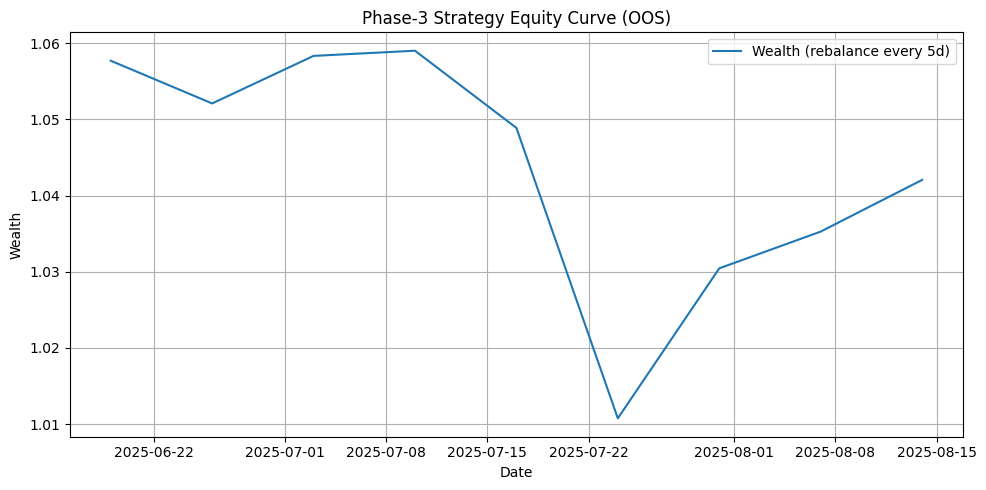

In [59]:
# ======================= PHASE 3 — RISK, PORTFOLIO & BACKTEST =======================
# Light deps (SciPy is preinstalled on Colab; install just in case)
!pip -q install scipy

# ---------------------------------- Imports ----------------------------------
import os, json, math, pathlib, warnings
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import xgboost as xgb

warnings.filterwarnings("ignore")

# --------------------------------- Paths/Utils --------------------------------
DATA_DIR = pathlib.Path("/content/data")
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

def utcnow():
    return datetime.now(timezone.utc)

def _load_phase1_assets():
    ft_path = PROC_DIR / "training_table.parquet"
    mdl_path = PROC_DIR / "xgb_model.json"
    cols_path = PROC_DIR / "feature_columns.json"
    assert ft_path.exists(), f"Missing {ft_path} (run Phase-1 first)."
    assert mdl_path.exists(), f"Missing {mdl_path} (run Phase-1 first)."
    assert cols_path.exists(), f"Missing {cols_path} (run Phase-1 first)."

    feat = pd.read_parquet(ft_path)
    booster = xgb.Booster(); booster.load_model(str(mdl_path))
    X_cols = json.loads(cols_path.read_text())
    return feat, booster, X_cols

# ------------------------------ Alpha Scoring --------------------------------
def score_xgb(feat: pd.DataFrame, booster: xgb.Booster, X_cols: List[str]) -> np.ndarray:
    X = feat[X_cols].astype(float).values
    dmat = xgb.DMatrix(X, feature_names=X_cols)
    # Version-safe prediction
    try:
        proba = booster.predict(dmat, iteration_range=(0, getattr(booster, "best_iteration", 0)+1))
    except TypeError:
        proba = booster.predict(dmat, ntree_limit=getattr(booster, "best_ntree_limit", 0) or None)
    return np.asarray(proba)

def latest_snapshot(feat: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """One row per company for the latest date, with required columns available."""
    idx = feat.groupby("company")["date"].idxmax()
    snap = feat.loc[idx].copy()
    snap = snap.sort_values("company").reset_index(drop=True)
    return snap

def alpha_to_expected_5d_return(p: np.ndarray, scale: float = 0.10) -> np.ndarray:
    """
    Map classifier prob to an expected 5-day return.
    scale=0.10 → (p=1.0) ≈ +10% over 5D; (p=0.5) ≈ 0%; (p=0.0) ≈ −10%.
    Tune 'scale' later with calibration.
    """
    return scale * (p - 0.5) * 2.0

# ------------------------------ Risk Model -----------------------------------
@dataclass
class RiskConfig:
    lookback_days: int = 60
    shrinkage: float = 0.2      # Ledoit-Wolf-like simple shrinkage toward diagonal
    ridge: float = 1e-6         # ensure PD

def _cov_shrink(S: np.ndarray, shrink: float, ridge: float) -> np.ndarray:
    d = np.diag(np.diag(S))
    Sigma = (1.0 - shrink) * S + shrink * d
    Sigma += ridge * np.eye(Sigma.shape[0])
    return Sigma

def build_cov_from_prices(prc_wide: pd.DataFrame, names: List[str], cfg: RiskConfig) -> Tuple[np.ndarray, pd.Index]:
    """
    prc_wide: index=date, columns=company, values=close
    returns Sigma (nxn) aligned to 'cols', and the actual columns used
    """
    # restrict to selected names and lookback window
    prc = prc_wide[names].dropna(how="all")
    if prc.empty:
        raise ValueError("No prices available to build covariance.")
    prc = prc.iloc[-cfg.lookback_days:]
    rets = prc.pct_change().dropna(how="all")
    rets = rets.dropna(axis=1)  # drop columns fully NaN within window
    cols = rets.columns
    if len(cols) < 2:
        raise ValueError("Not enough assets with valid history to build covariance.")
    S = np.cov(rets[cols].T)
    Sigma = _cov_shrink(S, cfg.shrinkage, cfg.ridge)
    return Sigma, cols

# ---------------------------- Markowitz Optimizer ----------------------------
@dataclass
class PortConfig:
    max_w: float      = 0.15    # per-name cap
    cash_buffer: float = 0.00   # hold a bit of cash
    risk_aversion: float = 6.0  # higher → more risk penalty
    long_only: bool = True

def mean_var_opt(mu: np.ndarray, Sigma: np.ndarray, names: List[str], cfg: PortConfig) -> pd.Series:
    n = len(names)
    mu = mu[:n]; Sigma = Sigma[:n, :n]

    # Objective: 0.5*w' Σ w * RA  −  mu' w  (we minimize)
    def objective(w):
        return 0.5 * cfg.risk_aversion * float(w @ Sigma @ w) - float(mu @ w)

    # Constraints: sum w = (1 − cash_buffer), bounds [0, max_w] if long_only else [-max_w, max_w]
    target_sum = 1.0 - cfg.cash_buffer
    cons = [{"type":"eq", "fun": lambda w: np.sum(w) - target_sum}]
    if cfg.long_only:
        bnds = [(0.0, cfg.max_w)] * n
    else:
        bnds = [(-cfg.max_w, cfg.max_w)] * n

    w0 = np.full(n, target_sum / n)  # start equal-weight

    res = minimize(objective, w0, method="SLSQP", bounds=bnds, constraints=cons, options={"maxiter": 10_000})
    if not res.success:
        raise RuntimeError(f"Optimizer failed: {res.message}")
    return pd.Series(res.x, index=names).sort_values(ascending=False)

# --------------------------- Backtest (walk-forward) -------------------------
def backtest_equal_weight_topk(feat: pd.DataFrame,
                               booster: xgb.Booster,
                               X_cols: List[str],
                               top_k: int = 8,
                               hold_days: int = 5) -> pd.DataFrame:
    """
    Out-of-sample backtest on the **test period** (last 20% of Phase-1 table).
    Rebalance every 'hold_days'. Equal-weight among top-k by XGB prob.
    """
    df = feat.sort_values("date").copy()

    # Identify test window (same 80/20 split as Phase-1 training)
    cutoff = df["date"].sort_values().iloc[int(len(df)*0.8)]
    test_df = df[df["date"] > cutoff].copy()

    # Predict proba per row in the test window
    test_df["proba"] = score_xgb(test_df[X_cols], booster, X_cols)

    # Realized 5D forward return from closes
    test_df["fwd_5d"] = test_df.groupby("company")["close"].shift(-hold_days) / test_df["close"] - 1.0

    # Rebalance dates ~ every 'hold_days'
    dates = sorted(test_df["date"].unique())
    rebal_dates = dates[::hold_days]
    curve = []
    wealth = 1.0

    for d in rebal_dates:
        slice_d = test_df[test_df["date"] == d].dropna(subset=["proba","fwd_5d"])
        if slice_d.empty:
            continue
        picks = slice_d.nlargest(top_k, "proba")
        port_ret = picks["fwd_5d"].mean()   # equal-weight
        wealth *= (1.0 + float(port_ret))
        curve.append({"date": d, "port_ret": float(port_ret), "wealth": wealth})

    eq = pd.DataFrame(curve).set_index("date")
    if not eq.empty:
        # metrics
        rets = eq["port_ret"].values
        avg = np.mean(rets)
        vol = np.std(rets)
        sharpe = (avg/vol) * math.sqrt(252/hold_days) if vol > 0 else 0.0
        total = eq["wealth"].iloc[-1] - 1.0
        print(f"[Backtest] top_k={top_k}, hold={hold_days}d | Total={total:.2%} | "
              f"Avg per block={avg:.2%} | Vol={vol:.2%} | Sharpe≈{sharpe:.2f}")
    else:
        print("Backtest produced no trades (check data).")
    # Save
    outp = PROC_DIR / f"bt_eq_top{top_k}_h{hold_days}.csv"
    eq.to_csv(outp)
    print("Backtest curve saved:", outp)
    return eq

# --------------------------- Today’s Portfolio Plan --------------------------
def todays_portfolio(feat: pd.DataFrame,
                     booster: xgb.Booster,
                     X_cols: List[str],
                     risk_cfg: RiskConfig = RiskConfig(),
                     port_cfg: PortConfig = PortConfig(),
                     top_k: int = 15) -> pd.DataFrame:
    """
    1) Take latest snapshot per company
    2) Score XGB
    3) Build expected 5D return vector mu
    4) Build covariance from last 60 days of closes
    5) Optimize weights with caps & long-only
    """
    snap = latest_snapshot(feat, X_cols + ["company","date","close"])
    snap["proba"] = score_xgb(snap[X_cols], booster, X_cols)
    snap["mu_5d"] = alpha_to_expected_5d_return(snap["proba"].values, scale=0.10)

    # Pick top names to feed the optimizer (keeps Sigma well-conditioned)
    snap = snap.nlargest(top_k, "proba").copy()

    # Price wide for covariance
    price_wide = feat.pivot_table(index="date", columns="company", values="close")
    Sigma, used_cols = build_cov_from_prices(price_wide, list(snap["company"].values), risk_cfg)

    # Align mu with used_cols
    snap_used = snap.set_index("company").loc[used_cols]
    mu = snap_used["mu_5d"].values

    weights = mean_var_opt(mu, Sigma, list(used_cols), port_cfg)
    out = snap_used[["date","close","proba","mu_5d"]].copy()
    out["weight"] = weights.reindex(out.index).fillna(0.0)
    out = out.sort_values("weight", ascending=False).reset_index().rename(columns={"index":"company"})

    # portfolio stats
    w = out["weight"].values
    mu_port = float(w @ mu)
    vol_port = float(np.sqrt(w @ Sigma @ w))
    print(f"[Portfolio] names={len(out)}, sum_w={w.sum():.2f}, exp_5d={mu_port:.2%}, risk≈{vol_port:.2%}")
    # Save
    outp = PROC_DIR / f"portfolio_plan_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    out.to_csv(outp, index=False)
    print("Portfolio plan saved:", outp)
    return out

# --------------------------------- RUNS -------------------------------------
feat, booster, X_cols = _load_phase1_assets()

print(f"[{utcnow().isoformat()}] Phase-3 starting…")

# 1) Build “today” portfolio (Markowitz with caps)
port = todays_portfolio(
    feat=feat,
    booster=booster,
    X_cols=X_cols,
    risk_cfg=RiskConfig(lookback_days=60, shrinkage=0.25, ridge=1e-6),
    port_cfg=PortConfig(max_w=0.15, cash_buffer=0.00, risk_aversion=6.0, long_only=True),
    top_k=15,      # optimize over top-15 ranked names
)
display(port.head(20))

# 2) Backtest on the out-of-sample window (equal-weight, weekly hold)
eq = backtest_equal_weight_topk(
    feat=feat,
    booster=booster,
    X_cols=X_cols,
    top_k=8,
    hold_days=5
)

# 3) Plot equity curve
if not eq.empty:
    plt.figure(figsize=(10,5))
    plt.plot(eq.index, eq["wealth"], label="Wealth (rebalance every 5d)")
    plt.title("Phase-3 Strategy Equity Curve (OOS)")
    plt.xlabel("Date"); plt.ylabel("Wealth")
    plt.grid(True); plt.legend(); plt.tight_layout()
    out_img = PROC_DIR / "bt_equity_curve.png"
    plt.savefig(out_img, dpi=150)
    print("Equity curve saved:", out_img)
# =============================================================================

# PHASE 4

In [60]:
# ===================== Phase-4 Hotfix: dedupe + robust access =====================

def latest_snapshot(feat: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """
    Return one latest row per company with only the requested columns.
    Ensures no duplicated column names.
    """
    # latest row per company
    idx = feat.groupby("company")["date"].idxmax()
    snap = feat.loc[idx].copy().sort_values("company").reset_index(drop=True)

    base = ["company","date","close"]
    # incoming `cols` may already contain base; keep order but de-dup
    need = [*base, *cols]
    need = [c for i,c in enumerate(need) if c in snap.columns and c not in need[:i]]  # order-preserving de-dup

    snap = snap[need].copy()
    # absolute safety: if any duplicate snuck in, drop duplicates keeping first
    if snap.columns.duplicated().any():
        snap = snap.loc[:, ~snap.columns.duplicated()].copy()
    return snap

def build_blended_mu5d(feat: pd.DataFrame,
                       booster: xgb.Booster,
                       X_cols: List[str],
                       blend: 'BlendWeights' = None,
                       scale_mu: float = 0.10,
                       horizon_days: int = 5) -> pd.DataFrame:
    """
    Returns DataFrame with company, date, close, component mus, z-scores, and final mu_blend.
    Robust against duplicate columns and missing price history.
    """
    if blend is None:
        blend = BlendWeights()

    # Build snapshot (no duplicate cols)
    snap = latest_snapshot(feat, X_cols)

    # Phase-1 probas
    p = score_xgb(snap, booster, X_cols)
    snap["xgb_prob"] = p
    snap["xgb_mu"]   = map_prob_to_mu5d(p, scale=scale_mu)

    # Wide price matrix
    price_wide = feat.pivot_table(index="date", columns="company", values="close").sort_index()

    fc_list, lstm_list = [], []
    for _, row in snap.iterrows():
        comp = row["company"]
        # If a duplicate "company" column slipped in, row["company"] becomes a Series; take first
        if not isinstance(comp, (str,)):
            try:
                comp = comp.iloc[0]
            except Exception:
                comp = str(comp)

        comp = str(comp)
        if comp not in price_wide.columns:
            # no history available → neutral components
            fc_list.append(np.nan)
            lstm_list.append(np.nan)
            continue

        px_series = price_wide[comp].dropna()
        today_close = float(row["close"])
        # Forecast drift (Prophet→ARIMA→linear)
        fc = _forecast_drift_5d(comp, price_wide, today_close, horizon_days=horizon_days)
        fc_list.append(fc if (fc is not None and np.isfinite(fc)) else np.nan)

        # LSTM 5d up-prob (or momentum-logistic fallback)
        p5 = _load_lstm_prob_up(comp, px_series, lookback=30)
        lstm_list.append(p5 if (p5 is not None and np.isfinite(p5)) else np.nan)

    snap["fc_mu"]    = pd.Series(fc_list, index=snap.index, dtype="float64")
    snap["lstm_mu"]  = map_prob_to_mu5d(pd.Series(lstm_list, index=snap.index).fillna(0.5).values, scale=scale_mu)

    # Cross-sectional z-scoring
    snap["z_xgb"]  = zscore(snap["xgb_mu"].fillna(0.0))
    snap["z_fc"]   = zscore(snap["fc_mu"].fillna(0.0))
    snap["z_lstm"] = zscore(snap["lstm_mu"].fillna(0.0))

    z_blend = (blend.wxgb*snap["z_xgb"] + blend.wfc*snap["z_fc"] + blend.wlstm*snap["z_lstm"])
    z_blend /= (abs(blend.wxgb)+abs(blend.wfc)+abs(blend.wlstm))
    snap["mu_blend"] = z_blend * scale_mu

    out_cols = ["company","date","close","xgb_prob","xgb_mu","fc_mu","lstm_mu","z_xgb","z_fc","z_lstm","mu_blend"]
    out = snap[out_cols].sort_values("mu_blend", ascending=False).reset_index(drop=True)

    diag_path = PROC_DIR / f"alpha_blend_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    out.to_csv(diag_path, index=False)
    print("Blended alpha table saved:", diag_path)
    return out

# Also fix the small rename glitch when saving the plan later:
def _safe_plan_from_weights(sel_used: pd.DataFrame, w: pd.Series) -> pd.DataFrame:
    plan = sel_used[["date","close","xgb_prob","xgb_mu","fc_mu","lstm_mu","mu_blend"]].copy()
    plan["weight"] = w.reindex(plan.index).fillna(0.0)
    # bring the index (company) back as a column cleanly
    plan = plan.reset_index().rename(columns={"index":"company"})
    return plan

In [61]:
# ======================= PHASE 4 — ALPHA BLENDER + COSTS (FIXED) =======================
!pip -q install scipy pmdarima prophet --upgrade || echo "If Prophet fails, ARIMA/momentum will be used."

# ---------------------------------- Imports ----------------------------------
import os, json, math, pathlib, warnings, gc
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone

from scipy.optimize import minimize
import xgboost as xgb

warnings.filterwarnings("ignore")

# Optional TS libs
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
except Exception:
    PMDARIMA_AVAILABLE = False

# TensorFlow optional (for loading per-ticker LSTM if available)
try:
    import tensorflow as tf
    from tensorflow import keras
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False

# --------------------------------- Paths/Utils --------------------------------
DATA_DIR = pathlib.Path("/content/data")
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

def utcnow():
    return datetime.now(timezone.utc)

def _load_phase1_assets():
    ft_path = PROC_DIR / "training_table.parquet"
    mdl_path = PROC_DIR / "xgb_model.json"
    cols_path = PROC_DIR / "feature_columns.json"
    assert ft_path.exists(), f"Missing {ft_path} (run Phase-1 first)."
    assert mdl_path.exists(), f"Missing {mdl_path} (run Phase-1 first)."
    assert cols_path.exists(), f"Missing {cols_path} (run Phase-1 first)."
    feat = pd.read_parquet(ft_path)
    booster = xgb.Booster(); booster.load_model(str(mdl_path))
    X_cols = json.loads(cols_path.read_text())
    return feat, booster, X_cols

# ------------------------------ Helpers from Phase-1 --------------------------
def score_xgb(feat_rows: pd.DataFrame, booster: xgb.Booster, X_cols: List[str]) -> np.ndarray:
    X = feat_rows[X_cols].astype(float).values
    dmat = xgb.DMatrix(X, feature_names=X_cols)
    try:
        proba = booster.predict(dmat, iteration_range=(0, getattr(booster, "best_iteration", 0)+1))
    except TypeError:
        proba = booster.predict(dmat, ntree_limit=getattr(booster, "best_ntree_limit", 0) or None)
    return np.asarray(proba)

def map_prob_to_mu5d(p: np.ndarray, scale: float = 0.10) -> np.ndarray:
    """p=0.5→0%; p=1→+scale; p=0→-scale over 5d."""
    return scale * (p - 0.5) * 2.0

def zscore(x: pd.Series) -> pd.Series:
    mu, sd = x.mean(), x.std(ddof=0)
    if sd == 0 or np.isnan(sd):
        return pd.Series(np.zeros_like(x), index=x.index)
    return (x - mu) / sd

# ------------------------------ Dedupe-safe snapshot -------------------------
def latest_snapshot(feat: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Return one latest row per company with only requested columns. No duplicate names."""
    # ensure base columns exist
    assert {"company","date","close"}.issubset(feat.columns), "feat must have company/date/close"

    # most recent per company
    idx = feat.groupby("company")["date"].idxmax()
    snap = feat.loc[idx].copy().sort_values("company").reset_index(drop=True)

    # order-preserving de-dup of requested columns plus base
    base = ["company","date","close"]
    req = base + cols
    need = []
    for c in req:
        if c in snap.columns and c not in need:
            need.append(c)
    snap = snap[need].copy()

    # hard guard against duplicate column names
    if snap.columns.duplicated().any():
        snap = snap.loc[:, ~snap.columns.duplicated()].copy()

    # normalize company names to clean strings
    snap["company"] = snap["company"].astype(str).str.strip()

    # normalize dates (naive)
    snap["date"] = pd.to_datetime(snap["date"]).dt.tz_localize(None)

    # make sure close is numeric
    snap["close"] = pd.to_numeric(snap["close"], errors="coerce")

    return snap

# ------------------------------ Forecast piece --------------------------------
def _forecast_drift_5d(sym: str, price_wide: pd.DataFrame, today_close: float, horizon_days: int = 5) -> Optional[float]:
    """Expected 5d drift ratio (forecast/last_close - 1). Prophet→ARIMA→linear fallback."""
    if sym not in price_wide.columns:
        return None
    s = price_wide[sym].dropna()
    if s.empty or len(s) < 60:
        return None
    df = s.rename("y").reset_index().rename(columns={"date":"ds"})
    df["ds"] = pd.to_datetime(df["ds"])

    # Prophet
    if PROPHET_AVAILABLE:
        try:
            m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
            m.fit(df[["ds","y"]])
            fut = m.make_future_dataframe(periods=horizon_days, freq="D")
            fc  = m.predict(fut).tail(horizon_days)["yhat"].values
            yhat = float(np.mean(fc))
            return (yhat / today_close) - 1.0
        except Exception:
            pass

    # Auto-ARIMA
    if PMDARIMA_AVAILABLE:
        try:
            model = pm.auto_arima(df["y"], seasonal=False, error_action="ignore", suppress_warnings=True)
            preds = model.predict(n_periods=horizon_days)
            yhat  = float(np.mean(preds))
            return (yhat / today_close) - 1.0
        except Exception:
            pass

    # Linear trend fallback
    try:
        tail = df.tail(120)
        if len(tail) < 30:
            return None
        x = np.arange(len(tail))
        y = tail["y"].values
        A = np.vstack([x, np.ones_like(x)]).T
        slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
        next_x = np.arange(len(tail), len(tail)+horizon_days)
        preds = slope*next_x + intercept
        yhat = float(np.mean(preds))
        return (yhat / today_close) - 1.0
    except Exception:
        return None

# ------------------------------ LSTM component -------------------------------
def _load_lstm_prob_up(sym: str, price_series: pd.Series, lookback: int = 30) -> Optional[float]:
    """Use saved per-ticker LSTM if available; else logistic on momentum."""
    sym_key = sym.replace(":","_").replace("/","_")
    model_path = PROC_DIR / f"lstm_{sym_key}.keras"
    r = price_series.pct_change().dropna().values.astype("float32")
    if len(r) <= lookback + 2:
        return None
    seq = r[-lookback:].reshape(1, lookback, 1)
    if TF_AVAILABLE and model_path.exists():
        try:
            model = keras.models.load_model(str(model_path))
            p1 = float(model.predict(seq, verbose=0).ravel()[0])
            p5 = 1.0 - (1.0 - p1)**5
            return p5
        except Exception:
            pass
    # momentum → prob fallback
    try:
        mom = float((price_series.iloc[-1] / price_series.iloc[-(lookback+1)]) - 1.0)
        p1 = 1.0 / (1.0 + math.exp(- mom / 0.02))
        p5 = 1.0 - (1.0 - p1)**5
        return p5
    except Exception:
        return None

# --------------------------- Blended alpha builder ----------------------------
@dataclass
class BlendWeights:
    wxgb: float = 0.55
    wfc:  float = 0.30
    wlstm:float = 0.15

def build_blended_mu5d(feat: pd.DataFrame,
                       booster: xgb.Booster,
                       X_cols: List[str],
                       blend: BlendWeights = BlendWeights(),
                       scale_mu: float = 0.10,
                       horizon_days: int = 5) -> pd.DataFrame:
    """Return DataFrame with company, date, close, component mus, z-scores, final mu_blend."""
    # Clean snapshot with *only* X_cols requested; function adds base safely.
    snap = latest_snapshot(feat, X_cols)

    # Score Phase-1
    p = score_xgb(snap, booster, X_cols)
    snap["xgb_prob"] = p
    snap["xgb_mu"]   = map_prob_to_mu5d(p, scale=scale_mu)

    # Build wide price matrix (guarantee string column names)
    price_wide = feat.pivot_table(index="date", columns="company", values="close").sort_index()
    price_wide.columns = price_wide.columns.map(lambda s: str(s).strip())

    # Components per name
    fc_list, lstm_list = [], []
    for _, row in snap.iterrows():
        comp = str(row["company"]).strip()

        # Forecast drift
        fc = _forecast_drift_5d(comp, price_wide, float(row["close"]), horizon_days=horizon_days)
        fc_list.append(fc if (fc is not None and np.isfinite(fc)) else np.nan)

        # LSTM 5d up-prob
        px_series = price_wide[comp].dropna() if comp in price_wide.columns else pd.Series(dtype=float)
        p5 = _load_lstm_prob_up(comp, px_series, lookback=30) if not px_series.empty else None
        lstm_list.append(p5 if (p5 is not None and np.isfinite(p5)) else np.nan)

    snap["fc_mu"]    = pd.Series(fc_list, index=snap.index, dtype="float64")
    snap["lstm_mu"]  = map_prob_to_mu5d(pd.Series(lstm_list, index=snap.index).fillna(0.5).values, scale=scale_mu)

    # Cross-sectional z’s → blended μ
    snap["z_xgb"]  = zscore(snap["xgb_mu"].fillna(0.0))
    snap["z_fc"]   = zscore(snap["fc_mu"].fillna(0.0))
    snap["z_lstm"] = zscore(snap["lstm_mu"].fillna(0.0))

    z_blend = (blend.wxgb*snap["z_xgb"] + blend.wfc*snap["z_fc"] + blend.wlstm*snap["z_lstm"])
    z_blend /= (abs(blend.wxgb)+abs(blend.wfc)+abs(blend.wlstm))
    snap["mu_blend"] = z_blend * scale_mu

    out_cols = ["company","date","close","xgb_prob","xgb_mu","fc_mu","lstm_mu","z_xgb","z_fc","z_lstm","mu_blend"]
    out = snap[out_cols].sort_values("mu_blend", ascending=False).reset_index(drop=True)

    diag_path = PROC_DIR / f"alpha_blend_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    out.to_csv(diag_path, index=False)
    print("Blended alpha table saved:", diag_path)
    return out

# ---------------------------- Risk & Optimizer -------------------------------
@dataclass
class RiskConfig:
    lookback_days: int = 60
    shrinkage: float = 0.25
    ridge: float = 1e-6

def _cov_shrink(S: np.ndarray, shrink: float, ridge: float) -> np.ndarray:
    d = np.diag(np.diag(S))
    Sigma = (1.0 - shrink) * S + shrink * d
    Sigma += ridge * np.eye(Sigma.shape[0])
    return Sigma

def build_cov_from_prices(prc_wide: pd.DataFrame, names: List[str], cfg: RiskConfig) -> Tuple[np.ndarray, pd.Index]:
    # keep only selected names (stringified)
    names = [str(n).strip() for n in names]
    prc = prc_wide[[c for c in names if c in prc_wide.columns]].dropna(how="all")
    prc = prc.iloc[-cfg.lookback_days:]
    rets = prc.pct_change().dropna(how="all").dropna(axis=1)
    cols = rets.columns
    if len(cols) < 2:
        print(f"Warning: Not enough assets ({len(cols)}) with valid history to build covariance. Using identity.")
        n = len(names)
        return np.eye(n) * 0.01, pd.Index(names)
    S = np.cov(rets[cols].T)
    return _cov_shrink(S, cfg.shrinkage, cfg.ridge), cols

@dataclass
class PortConfig:
    max_w: float      = 0.15
    cash_buffer: float = 0.00
    risk_aversion: float = 6.0
    long_only: bool = True
    turn_penalty: float = 10.0
    tcost_bps: float = 5.0

def _load_previous_weights() -> Optional[pd.Series]:
    files = sorted(PROC_DIR.glob("portfolio_plan_*.csv"))
    if not files:
        return None
    last = files[-1]
    prev = pd.read_csv(last)
    if "company" in prev.columns and "weight" in prev.columns:
        return prev.set_index("company")["weight"]
    return None

def optimize_with_costs(mu: np.ndarray, Sigma: np.ndarray, names: List[str],
                        port_cfg: PortConfig, prev_w: Optional[pd.Series]) -> pd.Series:
    n = len(names)
    # guard: align shapes
    if Sigma.shape[0] != len(mu):
        print(f"Warning: Mu length ({len(mu)}) != Sigma size ({Sigma.shape[0]}). Using identity Sigma.")
        Sigma = np.eye(len(mu)) * 0.01
        names = names[:len(mu)]

    target_sum = 1.0 - port_cfg.cash_buffer

    # align previous weights
    w_prev = np.zeros(len(mu))
    if prev_w is not None:
        prev_w = prev_w.reindex(names).fillna(0.0)
        w_prev = prev_w.values

    tcost = port_cfg.tcost_bps / 1e4
    def smooth_abs(x, eps=1e-3): return np.sqrt(x*x + eps*eps)
    def objective(w):
        risk = 0.5 * port_cfg.risk_aversion * float(w @ Sigma @ w)
        exp  = - float(mu @ w)
        turn = port_cfg.turn_penalty * float(((w - w_prev) @ (w - w_prev)))
        cost = tcost * float(np.sum(smooth_abs(w - w_prev)))
        return risk + exp + turn + cost

    cons = [{"type":"eq", "fun": lambda w: np.sum(w) - target_sum}]
    bnds = [(0.0, port_cfg.max_w)] * len(mu) if port_cfg.long_only else [(-port_cfg.max_w, port_cfg.max_w)] * len(mu)

    w0 = np.clip(w_prev, bnds[0][0], bnds[0][1])
    if abs(w0.sum()) < 1e-8:
        w0 = np.full(len(mu), target_sum / len(mu))

    res = minimize(objective, w0, method="SLSQP", bounds=bnds, constraints=cons, options={"maxiter": 20_000})
    if not res.success:
        raise RuntimeError(f"Optimizer failed: {res.message}")
    return pd.Series(res.x, index=names).sort_values(ascending=False)

def _safe_plan_from_weights(sel_used: pd.DataFrame, w: pd.Series) -> pd.DataFrame:
    plan = sel_used[["date","close","xgb_prob","xgb_mu","fc_mu","lstm_mu","mu_blend"]].copy()
    plan["weight"] = w.reindex(plan.index).fillna(0.0)
    plan = plan.reset_index().rename(columns={"index":"company"})
    return plan

# --------------------------------- RUN BLEND --------------------------------
feat, booster, X_cols = _load_phase1_assets()

print(f"[{utcnow().isoformat()}] Phase-4 starting…")

# Build blended μ across latest snapshot (5D horizon)
blend_diag = build_blended_mu5d(
    feat=feat, booster=booster, X_cols=X_cols,
    blend=BlendWeights(wxgb=0.55, wfc=0.30, wlstm=0.15),
    scale_mu=0.10, horizon_days=5
)
display(blend_diag.head(10))

# Risk inputs from closes
price_wide = feat.pivot_table(index="date", columns="company", values="close").sort_index()
price_wide.columns = price_wide.columns.map(lambda s: str(s).strip())

# Select top names by mu_blend
top_k = 15
sel = blend_diag.nlargest(top_k, "mu_blend").copy()
names = [str(n).strip() for n in sel["company"].tolist()]

if len(names) < 2:
    print(f"Warning: Only {len(names)} asset(s) selected. Skipping optimization.")
    plan = sel[["company","date","close","xgb_prob","xgb_mu","fc_mu","lstm_mu","mu_blend"]].copy()
    plan["weight"] = 1.0 / len(names) if len(names) > 0 else 0.0
    plan = plan.sort_values("weight", ascending=False).reset_index(drop=True)
else:
    Sigma, used_cols = build_cov_from_prices(price_wide, names, RiskConfig(lookback_days=60, shrinkage=0.25, ridge=1e-6))
    # keep only used columns (companies present in Sigma)
    sel_used = sel.set_index("company").loc[[c for c in used_cols]]
    mu_vec = sel_used["mu_blend"].values

    prev_w = _load_previous_weights()
    port_cfg = PortConfig(max_w=0.15, cash_buffer=0.00, risk_aversion=6.0, long_only=True,
                          turn_penalty=10.0, tcost_bps=5.0)

    w = optimize_with_costs(mu_vec, Sigma, list(sel_used.index), port_cfg, prev_w)
    plan = _safe_plan_from_weights(sel_used, w)

    # Portfolio stats
    w_vec = plan["weight"].values
    mu_gross = float(w_vec @ mu_vec)
    if prev_w is not None:
        delta = np.abs(w.reindex(prev_w.index).fillna(0.0) - prev_w).sum()
    else:
        delta = np.sum(np.abs(w_vec))
    tcost = (port_cfg.tcost_bps / 1e4) * float(delta)
    mu_net = mu_gross - tcost
    print(f"[Blend Portfolio] names={len(plan)}, sum_w={plan['weight'].sum():.2f}, "
          f"exp_5d_gross={mu_gross:.2%}, est_cost={tcost:.2%}, exp_5d_net={mu_net:.2%}")

# Save plan
outp = PROC_DIR / f"portfolio_plan_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
plan.to_csv(outp, index=False)
print("Blended portfolio plan saved:", outp)

display(plan.head(20))
# =============================================================================

[2025-08-26T20:21:10.333853+00:00] Phase-4 starting…
Blended alpha table saved: /content/data/processed/alpha_blend_20250826_2021.csv


,company,date,close,xgb_prob,xgb_mu,fc_mu,lstm_mu,z_xgb,z_fc,z_lstm,mu_blend
0,Cholaman.Inv.&Fn,2025-08-26,1476.199951,0.501503,0.000301,0.038140,0.013054,0.817573,2.091619,0.426194,0.114108
1,M & M Fin. Serv.,2025-08-26,260.500000,0.501503,0.000301,0.004866,0.031823,0.817573,0.544020,0.671123,0.071354
2,Bank of India,2025-08-26,112.379997,0.500675,0.000135,0.009965,0.050624,0.618402,0.781153,0.916466,0.071194
3,SBI,2025-08-26,807.849976,0.500675,0.000135,0.002257,0.092723,0.618402,0.422681,1.465821,0.068680
4,Yes Bank,2025-08-26,18.950001,0.501503,0.000301,0.012386,-0.039846,0.817573,0.893767,-0.264108,0.067818
5,Shriram Finance,2025-08-26,594.700012,0.501503,0.000301,0.010521,-0.096353,0.817573,0.807044,-1.001483,0.054156
6,Aditya Birla Cap,2025-08-26,281.000000,0.501503,0.000301,-0.017873,0.099986,0.817573,-0.513624,1.560596,0.052967
7,Kotak Mah. Bank,2025-08-26,1965.699951,0.500675,0.000135,0.014863,-0.095553,0.618402,1.008969,-0.991042,0.049416
8,Union Bank (I),2025-08-26,129.669998,0.500675,0.000135,0.010571,-0.097276,0.618402,0.809356,-1.013531,0.043090
9,Punjab Natl.Bank,2025-08-26,102.769997,0.500675,0.000135,0.007340,-0.074551,0.618402,0.659079,-0.716976,0.043030


[Blend Portfolio] names=15, sum_w=1.00, exp_5d_gross=6.06%, est_cost=0.01%, exp_5d_net=6.05%
Blended portfolio plan saved: /content/data/processed/portfolio_plan_20250826_2021.csv


,company,date,close,xgb_prob,xgb_mu,fc_mu,lstm_mu,mu_blend,weight
0,Cholaman.Inv.&Fn,2025-08-26,1476.199951,0.501503,0.000301,0.038140,0.013054,0.114108,0.084119
1,M & M Fin. Serv.,2025-08-26,260.500000,0.501503,0.000301,0.004866,0.031823,0.071354,0.112307
2,Bank of India,2025-08-26,112.379997,0.500675,0.000135,0.009965,0.050624,0.071194,0.079651
3,SBI,2025-08-26,807.849976,0.500675,0.000135,0.002257,0.092723,0.068680,0.111447
4,Yes Bank,2025-08-26,18.950001,0.501503,0.000301,0.012386,-0.039846,0.067818,0.115886
5,Shriram Finance,2025-08-26,594.700012,0.501503,0.000301,0.010521,-0.096353,0.054156,0.087242
6,Aditya Birla Cap,2025-08-26,281.000000,0.501503,0.000301,-0.017873,0.099986,0.052967,0.067448
7,Kotak Mah. Bank,2025-08-26,1965.699951,0.500675,0.000135,0.014863,-0.095553,0.049416,0.099289
8,Union Bank (I),2025-08-26,129.669998,0.500675,0.000135,0.010571,-0.097276,0.043090,0.061072
9,Punjab Natl.Bank,2025-08-26,102.769997,0.500675,0.000135,0.007340,-0.074551,0.043030,0.074315


# PHASE 5

In [62]:
# =================== PHASE 5 — WALK-FORWARD BACKTEST & CALIBRATION ===================
# Reuses Phase-4 libraries (xgboost, prophet/pmdarima optional). Only SciPy needed here.
!pip -q install scipy --upgrade

import os, json, math, pathlib, warnings, gc
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
from datetime import datetime, timedelta, timezone
from scipy.optimize import minimize
import xgboost as xgb

warnings.filterwarnings("ignore")

# ---------- Optional time-series libs: Prophet / ARIMA (will fallback if missing) ----------
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
except Exception:
    PMDARIMA_AVAILABLE = False

# ---------- Optional TF for loading per-ticker LSTM if you trained & saved them ----------
try:
    import tensorflow as tf
    from tensorflow import keras
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False

# -------------------------------------- Paths --------------------------------------
DATA_DIR = pathlib.Path("/content/data")
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

def utcnow():
    return datetime.now(timezone.utc)

# ------------------------------- Load Phase-1 assets -------------------------------
def _load_phase1_assets():
    ft_path = PROC_DIR / "training_table.parquet"
    mdl_path = PROC_DIR / "xgb_model.json"
    cols_path = PROC_DIR / "feature_columns.json"
    assert ft_path.exists(), f"Missing {ft_path} (run Phase-1 first)."
    assert mdl_path.exists(), f"Missing {mdl_path} (run Phase-1 first)."
    assert cols_path.exists(), f"Missing {cols_path} (run Phase-1 first)."
    feat = pd.read_parquet(ft_path)
    # Ensure dtypes
    feat["date"] = pd.to_datetime(feat["date"]).dt.tz_localize(None)
    booster = xgb.Booster(); booster.load_model(str(mdl_path))
    X_cols = json.loads(cols_path.read_text())
    return feat, booster, X_cols

feat, booster, X_cols = _load_phase1_assets()
print(f"[{utcnow().isoformat()}] Phase-5: inputs loaded. rows={len(feat)} names={feat['company'].nunique()}")

# ----------------------------- Utility: forward 5D return -----------------------------
def add_fwd5(fe: pd.DataFrame) -> pd.DataFrame:
    fe = fe.sort_values(["company","date"]).copy()
    fe["fwd_ret_5d"] = fe.groupby("company")["close"].shift(-5) / fe["close"] - 1.0
    return fe

feat = add_fwd5(feat)

# ----------------------------- Z-score & probability mapping -----------------------------
def zscore(x: pd.Series) -> pd.Series:
    mu, sd = x.mean(), x.std(ddof=0)
    if sd == 0 or np.isnan(sd): return pd.Series(np.zeros_like(x), index=x.index)
    return (x - mu) / sd

def score_xgb(df_rows: pd.DataFrame, booster: xgb.Booster, X_cols: List[str]) -> np.ndarray:
    X = df_rows[X_cols].astype(float).values
    d = xgb.DMatrix(X, feature_names=X_cols)
    try:
        return booster.predict(d, iteration_range=(0, getattr(booster, "best_iteration", 0)+1))
    except TypeError:
        return booster.predict(d, ntree_limit=getattr(booster, "best_ntree_limit", 0) or None)

def _calibrate_scale_mu(train_slice: pd.DataFrame, booster: xgb.Booster, X_cols: List[str]) -> float:
    """
    Calibrate p->μ using only past data: regress realized fwd_ret_5d on (p-0.5)*2.
    Return a scale capped to [0.02, 0.15] for stability.
    """
    sl = train_slice.dropna(subset=X_cols + ["fwd_ret_5d"]).copy()
    if len(sl) < 1000:
        return 0.10
    p = score_xgb(sl, booster, X_cols)
    x = 2.0*(p - 0.5)
    y = sl["fwd_ret_5d"].values
    # simple OLS slope
    Xmat = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(Xmat, y, rcond=None)[0]
    scale = float(abs(slope))
    return float(np.clip(scale, 0.02, 0.15))

def map_prob_to_mu5d(p: np.ndarray, scale: float) -> np.ndarray:
    return scale * (p - 0.5) * 2.0

# --------------------------- Forecast drift & LSTM proxy ---------------------------
def _drift_5d_for_date(company: str, price_wide_up_to_d: pd.DataFrame, last_close: float, horizon=5) -> Optional[float]:
    s = price_wide_up_to_d[company].dropna()
    if s.empty or len(s) < 60: return None
    df = s.rename("y").reset_index().rename(columns={"date":"ds"})
    df["ds"] = pd.to_datetime(df["ds"])

    # Prophet first
    if PROPHET_AVAILABLE:
        try:
            m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
            m.fit(df[["ds","y"]])
            fut = m.make_future_dataframe(periods=horizon, freq="D")
            fc  = m.predict(fut).tail(horizon)["yhat"].values
            yhat = float(np.mean(fc))
            return (yhat/last_close) - 1.0
        except Exception:
            pass
    # ARIMA
    if PMDARIMA_AVAILABLE:
        try:
            model = pm.auto_arima(df["y"], seasonal=False, error_action="ignore", suppress_warnings=True)
            preds = model.predict(n_periods=horizon)
            yhat  = float(np.mean(preds))
            return (yhat/last_close) - 1.0
        except Exception:
            pass
    # Linear tail trend
    tail = df.tail(120)
    if len(tail) < 30: return None
    x = np.arange(len(tail)); y = tail["y"].values
    A = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    next_x = np.arange(len(tail), len(tail)+horizon)
    preds = slope*next_x + intercept
    yhat = float(np.mean(preds))
    return (yhat/last_close) - 1.0

def _lstm_prob5_for_date(sym: str, price_series_up_to_d: pd.Series, lookback=30) -> Optional[float]:
    """
    If a saved per-ticker LSTM exists, use it to get next-day up prob, then compound to 5d.
    Else use momentum→logistic fallback (uses only past data up to the date).
    """
    s = price_series_up_to_d.dropna()
    if len(s) <= lookback+2: return None
    # Try saved Keras
    path = PROC_DIR / f"lstm_{sym.replace(':','_').replace('/','_')}.keras"
    if TF_AVAILABLE and path.exists():
        try:
            r = s.pct_change().dropna().values.astype("float32")
            seq = r[-lookback:].reshape(1, lookback, 1)
            model = keras.models.load_model(str(path))
            p1 = float(model.predict(seq, verbose=0).ravel()[0])
            p5 = 1.0 - (1.0 - p1)**5
            return p5
        except Exception:
            pass
    # Fallback: momentum-logistic
    try:
        mom = float((s.iloc[-1] / s.iloc[-(lookback+1)]) - 1.0)
        p1  = 1.0 / (1.0 + math.exp(- mom / 0.02))
        p5  = 1.0 - (1.0 - p1)**5
        return p5
    except Exception:
        return None

# --------------------------------- Risk model ---------------------------------
@dataclass
class RiskConfig:
    lookback_days: int = 60
    shrinkage: float = 0.25
    ridge: float = 1e-6

def _cov_shrink(S: np.ndarray, shrink: float, ridge: float) -> np.ndarray:
    d = np.diag(np.diag(S))
    Sigma = (1.0 - shrink) * S + shrink * d
    Sigma += ridge * np.eye(Sigma.shape[0])
    return Sigma

def build_cov(price_wide_up_to_d: pd.DataFrame, names: List[str], cfg: RiskConfig) -> Tuple[np.ndarray, List[str]]:
    prc = price_wide_up_to_d[names].dropna(how="all")
    prc = prc.iloc[-cfg.lookback_days:]
    rets = prc.pct_change().dropna(how="all").dropna(axis=1)
    cols = rets.columns.tolist()
    if len(cols) < 2:
        raise ValueError("Not enough assets with valid history for covariance.")
    S = np.cov(rets[cols].T)
    return _cov_shrink(S, cfg.shrinkage, cfg.ridge), cols

# --------------------------------- Optimizer ---------------------------------
@dataclass
class PortConfig:
    max_w: float       = 0.15
    cash_buffer: float = 0.00
    risk_aversion: float = 6.0
    long_only: bool = True
    turn_penalty: float = 10.0
    tcost_bps: float = 5.0

def _smooth_abs(x, eps=1e-3):
    return np.sqrt(x*x + eps*eps)

def optimize_with_costs(mu: np.ndarray, Sigma: np.ndarray, names: list,
                        prev_w: pd.Series | None, cfg: PortConfig) -> pd.Series:
    """
    Feasibility-safe optimizer:
      • Shrinks target sum to the max feasible under caps (long-only).
      • Falls back to a capped, mu-proportional heuristic if SLSQP fails.
    """
    n = len(names)
    assert n == len(mu) == Sigma.shape[0] == Sigma.shape[1], "shape mismatch"

    # ---- target sum with feasibility guard ----
    raw_target = 1.0 - cfg.cash_buffer
    if cfg.long_only:
        capacity = n * cfg.max_w
        target_sum = min(raw_target, capacity)          # <-- key fix
        lb, ub = 0.0, cfg.max_w
    else:
        # For long/short you can keep equality at raw_target and bounds ±max_w.
        # If you want feasibility shrink here as well, adjust similarly.
        target_sum = raw_target
        lb, ub = -cfg.max_w, cfg.max_w

    # ---- previous weights aligned ----
    w_prev = np.zeros(n)
    if prev_w is not None:
        prev_w = prev_w.reindex(names).fillna(0.0)
        w_prev = prev_w.values

    tcost = cfg.tcost_bps / 1e4

    def obj(w):
        risk = 0.5 * cfg.risk_aversion * float(w @ Sigma @ w)
        exp  = - float(mu @ w)
        turn = cfg.turn_penalty * float(((w - w_prev) @ (w - w_prev)))
        cost = tcost * float(np.sum(_smooth_abs(w - w_prev)))
        return risk + exp + turn + cost

    cons = [{"type": "eq", "fun": lambda w, tgt=target_sum: np.sum(w) - tgt}]
    bnds = [(lb, ub)] * n

    # Feasible starting point: uniform within the cap
    if target_sum <= 0 or n == 0:
        return pd.Series(np.zeros(n), index=names)

    w0_each = min(ub, target_sum / n)
    w0 = np.full(n, w0_each)

    res = minimize(obj, w0, method="SLSQP", bounds=bnds, constraints=cons,
                   options={"maxiter": 10000, "ftol": 1e-9})

    if res.success and np.isfinite(res.fun):
        return pd.Series(res.x, index=names).sort_values(ascending=False)

    # ---------- Fallback: capped, mu-proportional heuristic ----------
    mu_clip = np.clip(mu, 0, None)  # long-only: ignore negative alpha
    if mu_clip.sum() <= 1e-12:
        # all non-positive → park in cash (respect target_sum shrink already applied)
        return pd.Series(np.zeros(n), index=names)

    w = mu_clip / mu_clip.sum()
    w = w * target_sum
    # enforce cap iteratively
    for _ in range(5):
        over = w > ub + 1e-12
        if not over.any():
            break
        excess = (w[over] - ub).sum()
        w[over] = ub
        under = ~over
        if under.any():
            add = (w[under] / w[under].sum()) * excess
            w[under] += add
    # final clamp & renorm to <= target_sum
    w = np.clip(w, lb, ub)
    s = w.sum()
    if s > target_sum + 1e-10:
        w *= (target_sum / s)
    return pd.Series(w, index=names).sort_values(ascending=False)
# ------------------------------- Backtest driver -------------------------------
@dataclass
class BTConfig:
    months_back: int = 6
    rebalance_every_days: int = 5
    top_k: int = 15
    risk: "RiskConfig" = field(default_factory=RiskConfig)
    port: "PortConfig" = field(default_factory=PortConfig)

def run_backtest(feat: pd.DataFrame, booster: xgb.Booster, X_cols: List[str], cfg: BTConfig):
    # Price matrix
    price_wide = feat.pivot_table(index="date", columns="company", values="close").sort_index()
    dates = price_wide.index.to_list()
    if len(dates) < 80:
        raise ValueError("Not enough history to backtest.")

    # Limit to last N months
    cutoff = dates[-1] - pd.DateOffset(months=cfg.months_back)
    price_wide = price_wide.loc[price_wide.index >= cutoff]
    dates = price_wide.index.to_list()

    # Rebalance dates = every Nth day but ensure enough lookahead for 5d returns
    step = cfg.rebalance_every_days
    rebal_idx = list(range(0, max(0, len(dates)-step-1), step))
    rebal_dates = [dates[i] for i in rebal_idx if i+step < len(dates)]

    # Storage
    records = []
    equity = []
    nav = 1.0
    prev_w = None

    # Precompute company list present most of the time
    universe = price_wide.columns.tolist()

    for d in rebal_dates:
        # Build snapshot at date d
        snap = feat[feat["date"] == d].copy()
        if snap.empty:
            continue
        # Only keep intersection with universe (sanity)
        snap = snap[snap["company"].isin(universe)].copy()

        # Calibrate mapping on *past* data only
        train_slice = feat[(feat["date"] < d)].copy()
        scale_mu = _calibrate_scale_mu(train_slice, booster, X_cols)

        # XGB μ
        p = score_xgb(snap, booster, X_cols)
        snap["xgb_mu"] = map_prob_to_mu5d(p, scale=scale_mu)

        # TS components from truncated history up to d
        pw_trunc = price_wide.loc[:d].copy()
        fc_list, lstm_list = [], []
        for comp in snap["company"]:
            px = pw_trunc[comp].dropna()
            if px.empty:
                fc_list.append(np.nan); lstm_list.append(np.nan); continue
            last_close = float(px.iloc[-1])
            fc = _drift_5d_for_date(comp, pw_trunc, last_close, horizon=5)
            fc_list.append(fc if (fc is not None and np.isfinite(fc)) else np.nan)
            p5 = _lstm_prob5_for_date(comp, px, lookback=30)
            lstm_list.append(p5 if (p5 is not None and np.isfinite(p5)) else np.nan)

        snap["fc_mu"]   = pd.Series(fc_list, index=snap.index, dtype="float64")
        # Map lstm prob to μ with same *current* scale_mu so components commensurate
        lstm_mu = map_prob_to_mu5d(pd.Series(lstm_list, index=snap.index).fillna(0.5).values, scale=scale_mu)
        snap["lstm_mu"] = lstm_mu

        # Z-scored cross-section
        snap["z_xgb"]  = zscore(snap["xgb_mu"].fillna(0.0))
        snap["z_fc"]   = zscore(snap["fc_mu"].fillna(0.0))
        snap["z_lstm"] = zscore(snap["lstm_mu"].fillna(0.0))

        # Blend (same weights as Phase-4, tweakable)
        wxgb, wfc, wlstm = 0.55, 0.30, 0.15
        z_blend = (wxgb*snap["z_xgb"] + wfc*snap["z_fc"] + wlstm*snap["z_lstm"]) / (abs(wxgb)+abs(wfc)+abs(wlstm))
        snap["mu_blend"] = z_blend * scale_mu

        # Keep top_k names for stability
        sel = snap.nlargest(cfg.top_k, "mu_blend").copy()
        names = sel["company"].tolist()

        # Risk on past window
        try:
            Sigma, used = build_cov(pw_trunc, names, cfg.risk)
        except Exception:
            # If covariance fails (too few names), skip this date
            continue
        sel = sel.set_index("company").loc[used]
        mu_vec = sel["mu_blend"].values

        # Optimize with costs/turnover
        w_series = optimize_with_costs(mu_vec, Sigma, list(sel.index), prev_w, cfg.port)

        # Transaction cost now (rebalance at d)
        tcost = (cfg.port.tcost_bps/1e4) * (np.abs(w_series - (prev_w.reindex(w_series.index) if prev_w is not None else 0.0)).fillna(0.0).sum())

        # Realize 5D portfolio return (price change from d to d+5 on used names)
        d_next_idx = dates.index(d) + step
        if d_next_idx >= len(dates):
            break
        d2 = dates[d_next_idx]
        px0 = price_wide.loc[d,   used].astype(float)
        px1 = price_wide.loc[d2,  used].astype(float)
        ret_vec = (px1/px0 - 1.0).values
        port_ret = float(np.nansum(w_series.values * ret_vec))

        # Update NAV
        nav = nav * (1.0 + port_ret - tcost)
        equity.append({"date": d2, "nav": nav, "gross_5d": port_ret, "tcost": tcost})

        # Save records
        rec = sel.reset_index()[["mu_blend","xgb_mu","fc_mu","lstm_mu"]].copy()
        rec.insert(0, "date", d)
        rec.insert(1, "company", sel.index)
        rec["weight"] = w_series.values
        rec["scale_mu"] = scale_mu
        records.append(rec)

        prev_w = w_series  # carry forward
        # small GC to keep Colab happy on long loops
        if len(records) % 8 == 0:
            gc.collect()

    # Concatenate & save
    if not records or not equity:
        raise RuntimeError("Backtest produced no rounds. Check data availability.")
    diag = pd.concat(records, ignore_index=True)
    eq = pd.DataFrame(equity).sort_values("date")
    diag_path = PROC_DIR / f"alpha_blend_BACKTEST_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    port_path = PROC_DIR / f"portfolio_backtest_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    curve_path= PROC_DIR / f"equity_curve_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    diag.to_csv(diag_path, index=False)
    eq.to_csv(curve_path, index=False)

    # Portfolio “last trade” snapshot for convenience
    last_plan = rec.copy()
    last_plan.to_csv(port_path, index=False)

    # Metrics
    returns = eq["gross_5d"].values
    # Approx annualization factor: ~252 trading days / 5 ≈ 50.4 rebalances
    k = 252/5.0
    avg = returns.mean(); std = returns.std(ddof=1) if len(returns)>1 else 0.0
    sharpe = (avg/std*np.sqrt(k)) if std>1e-12 else np.nan
    cagr = eq["nav"].iloc[-1]**(k/len(returns)) - 1.0
    mdd = (eq["nav"].cummax() - eq["nav"]).max() / eq["nav"].cummax().max()

    print(f"[BT] rounds={len(returns)}  CAGR={cagr:.2%}  Sharpe≈{sharpe:.2f}  MaxDD≈{mdd:.2%}")
    print("Saved:")
    print("  • blend diagnostics   →", diag_path)
    print("  • last portfolio plan →", port_path)
    print("  • equity curve        →", curve_path)
    return diag, eq, last_plan

# ------------------------------ Run the backtest ------------------------------
btcfg = BTConfig(
    months_back=6,                # change to 12 for a deeper run
    rebalance_every_days=5,       # weekly
    top_k=15,
    risk=RiskConfig(lookback_days=60, shrinkage=0.25, ridge=1e-6),
    port=PortConfig(max_w=0.15, cash_buffer=0.00, risk_aversion=6.0,
                    long_only=True, turn_penalty=10.0, tcost_bps=5.0)
)

diag, curve, last_plan = run_backtest(feat, booster, X_cols, btcfg)
display(curve.tail(10))
display(last_plan.head(20))
# =========================================================================================

[2025-08-26T20:21:17.621328+00:00] Phase-5: inputs loaded. rows=5866 names=24
[BT] rounds=24  CAGR=27.40%  Sharpe≈1.02  MaxDD≈11.16%
Saved:
  • blend diagnostics   → /content/data/processed/alpha_blend_BACKTEST_20250826_2022.csv
  • last portfolio plan → /content/data/processed/portfolio_backtest_20250826_2022.csv
  • equity curve        → /content/data/processed/equity_curve_20250826_2022.csv


,date,nav,gross_5d,tcost
14,2025-06-20,1.185844,-0.002767,0.000192
15,2025-06-27,1.222918,0.031327,0.000063
16,2025-07-04,1.207592,-0.012431,0.000101
17,2025-07-11,1.185886,-0.017897,0.000078
18,2025-07-18,1.174115,-0.009844,0.000083
19,2025-07-25,1.139166,-0.029658,0.000108
20,2025-08-01,1.094242,-0.039277,0.000159
21,2025-08-08,1.098984,0.004427,0.000093
22,2025-08-18,1.127610,0.026142,0.000094
23,2025-08-25,1.122246,-0.004648,0.000109


,date,company,mu_blend,xgb_mu,fc_mu,lstm_mu,weight,scale_mu
0,2025-08-18,Aditya Birla Cap,0.284980,-0.000326,0.075564,0.149932,0.150000,0.15
1,2025-08-18,SBI,0.235519,0.000282,0.035546,0.149534,0.126191,0.15
2,2025-08-18,Indian Bank,0.209799,0.000282,0.018949,0.149992,0.123925,0.15
3,2025-08-18,M & M Fin. Serv.,0.199048,0.000282,0.013201,0.140403,0.111261,0.15
4,2025-08-18,Bank of India,0.031407,-0.009942,0.053422,0.064683,0.089525,0.15
5,2025-08-18,Bank of Baroda,0.016948,-0.010578,0.042740,0.146999,0.064826,0.15
6,2025-08-18,HDFC Bank,0.008740,-0.010578,0.037525,0.146477,0.062887,0.15
7,2025-08-18,Federal Bank,-0.006151,-0.010578,0.062109,-0.134416,0.057512,0.15
8,2025-08-18,Yes Bank,-0.006653,-0.009942,0.042143,-0.043854,0.042896,0.15
9,2025-08-18,Punjab Natl.Bank,-0.007340,-0.009942,0.035589,0.006404,0.039108,0.15


In [63]:
# =================== PHASE 5 — PATCHED CONFIG & RERUN ===================
# (Re-declare only what’s needed; assumes Phase-5 code already ran once.)

from dataclasses import dataclass
import numpy as np, pandas as pd, pathlib, json, math, gc
from datetime import datetime, timedelta, timezone
import xgboost as xgb
from scipy.optimize import minimize

# --- load Phase-1 artifacts ---
DATA_DIR = pathlib.Path("/content/data")
PROC_DIR = DATA_DIR / "processed"
feat = pd.read_parquet(PROC_DIR / "training_table.parquet")
booster = xgb.Booster(); booster.load_model(str(PROC_DIR / "xgb_model.json"))
X_cols = json.loads((PROC_DIR / "feature_columns.json").read_text())
feat["date"] = pd.to_datetime(feat["date"]).dt.tz_localize(None)

def utcnow(): return datetime.now(timezone.utc)

# --- helpers reused ---
def score_xgb(df_rows: pd.DataFrame, booster: xgb.Booster, X_cols):
    import xgboost as xgb
    X = df_rows[X_cols].astype(float).values
    d = xgb.DMatrix(X, feature_names=X_cols)
    try:
        return booster.predict(d, iteration_range=(0, getattr(booster, "best_iteration", 0)+1))
    except TypeError:
        return booster.predict(d, ntree_limit=getattr(booster, "best_ntree_limit", 0) or None)

def zscore(x: pd.Series):
    mu, sd = x.mean(), x.std(ddof=0)
    if sd == 0 or np.isnan(sd): return pd.Series(np.zeros_like(x), index=x.index)
    return (x - mu) / sd

def _calibrate_scale_mu(train_slice, booster, X_cols):
    sl = train_slice.dropna(subset=X_cols + ["fwd_ret_5d"]).copy()
    if len(sl) < 1000: return 0.10
    p = score_xgb(sl, booster, X_cols)
    x = 2.0*(p - 0.5)
    y = sl["fwd_ret_5d"].values
    Xmat = np.vstack([x, np.ones_like(x)]).T
    slope, _ = np.linalg.lstsq(Xmat, y, rcond=None)[0]
    return float(np.clip(abs(slope), 0.02, 0.15))

def map_prob_to_mu5d(p, scale): return scale * (p - 0.5) * 2.0

# --- tiny TS + LSTM proxies (same as Phase-5 logic) ---
try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
except Exception:
    PMDARIMA_AVAILABLE = False

try:
    import tensorflow as tf
    from tensorflow import keras
    TF_AVAILABLE = True
except Exception:
    TF_AVAILABLE = False

def _drift_5d_for_date(company, price_wide_up_to_d, last_close, horizon=5):
    s = price_wide_up_to_d[company].dropna()
    if s.empty or len(s) < 60: return None
    df = s.rename("y").reset_index().rename(columns={"date":"ds"})
    df["ds"] = pd.to_datetime(df["ds"])
    if PROPHET_AVAILABLE:
        try:
            m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
            m.fit(df[["ds","y"]])
            fut = m.make_future_dataframe(periods=horizon, freq="D")
            yhat = m.predict(fut).tail(horizon)["yhat"].mean()
            return float(yhat / last_close - 1.0)
        except Exception:
            pass
    if PMDARIMA_AVAILABLE:
        try:
            model = pm.auto_arima(df["y"], seasonal=False, error_action="ignore", suppress_warnings=True)
            preds = model.predict(n_periods=horizon)
            return float(np.mean(preds) / last_close - 1.0)
        except Exception:
            pass
    tail = df.tail(120)
    if len(tail) < 30: return None
    x = np.arange(len(tail)); y = tail["y"].values
    A = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    preds = slope*np.arange(len(tail), len(tail)+horizon) + intercept
    return float(np.mean(preds) / last_close - 1.0)

def _lstm_prob5_for_date(sym, price_series_up_to_d: pd.Series, lookback=30):
    s = price_series_up_to_d.dropna()
    if len(s) <= lookback+2: return None
    path = PROC_DIR / f"lstm_{sym.replace(':','_').replace('/','_')}.keras"
    if TF_AVAILABLE and path.exists():
        try:
            r = s.pct_change().dropna().values.astype("float32")
            seq = r[-lookback:].reshape(1, lookback, 1)
            model = keras.models.load_model(str(path))
            p1 = float(model.predict(seq, verbose=0).ravel()[0])
            return 1.0 - (1.0 - p1)**5
        except Exception:
            pass
    try:
        mom = float((s.iloc[-1] / s.iloc[-(lookback+1)]) - 1.0)
        p1  = 1.0 / (1.0 + math.exp(- mom / 0.02))
        return 1.0 - (1.0 - p1)**5
    except Exception:
        return None

# --- risk/optimizer (softened constraints) ---
from dataclasses import dataclass
from typing import List, Optional, Tuple

@dataclass
class RiskConfig:
    lookback_days: int = 60
    shrinkage: float = 0.25
    ridge: float = 1e-6

def _cov_shrink(S, shrink, ridge):
    d = np.diag(np.diag(S))
    Sigma = (1.0 - shrink) * S + shrink * d
    return Sigma + ridge * np.eye(Sigma.shape[0])

def build_cov(price_wide_up_to_d: pd.DataFrame, names: List[str], cfg: RiskConfig) -> Tuple[np.ndarray, List[str]]:
    prc = price_wide_up_to_d[names].dropna(how="all").iloc[-cfg.lookback_days:]
    rets = prc.pct_change().dropna(how="all").dropna(axis=1)
    cols = rets.columns.tolist()
    if len(cols) < 2:
        # fallback tiny-diagonal if too few names
        return np.eye(len(names)) * 0.01, names
    S = np.cov(rets[cols].T)
    return _cov_shrink(S, cfg.shrinkage, cfg.ridge), cols

@dataclass
class PortConfig:
    max_w: float       = 0.22     # PATCH: was 0.15
    cash_buffer: float = 0.05     # PATCH: add 5% cash slack
    risk_aversion: float = 6.0
    long_only: bool = True
    turn_penalty: float = 12.0    # PATCH: slightly higher turnover penalty
    tcost_bps: float = 5.0

def _smooth_abs(x, eps=1e-3): return np.sqrt(x*x + eps*eps)

def optimize_with_costs(mu, Sigma, names, prev_w: Optional[pd.Series], cfg: PortConfig):
    n = len(names)
    target_sum = 1.0 - cfg.cash_buffer
    w_prev = np.zeros(n)
    if prev_w is not None:
        prev_w = prev_w.reindex(names).fillna(0.0)
        w_prev = prev_w.values
    tcost = cfg.tcost_bps / 1e4

    def obj(w):
        risk = 0.5 * cfg.risk_aversion * float(w @ Sigma @ w)
        exp  = - float(mu @ w)
        turn = cfg.turn_penalty * float(((w - w_prev) @ (w - w_prev)))
        cost = tcost * float(np.sum(_smooth_abs(w - w_prev)))
        return risk + exp + turn + cost

    cons = [{"type":"eq","fun": lambda w: np.sum(w) - target_sum}]
    bnds = ([(0.0, cfg.max_w)]*n) if cfg.long_only else ([(-cfg.max_w, cfg.max_w)]*n)
    w0 = np.clip(w_prev, bnds[0][0], bnds[0][1])
    if abs(w0.sum()) < 1e-8:
        w0 = np.full(n, target_sum/n)

    res = minimize(obj, w0, method="SLSQP", bounds=bnds, constraints=cons, options={"maxiter": 20000})

    if not res.success:
        print(f"[WARN] Optimizer failed: {res.message} → falling back to proportional-to-mu allocation.")
        mu_pos = np.clip(mu, 0, None)
        if mu_pos.sum() <= 1e-9:
            w = np.full(n, target_sum/n)
        else:
            w = mu_pos / mu_pos.sum()
        # cap & rescale
        w = np.minimum(w, cfg.max_w)
        if w.sum() > target_sum:
            w *= target_sum / w.sum()
        return pd.Series(w, index=names).sort_values(ascending=False)

    return pd.Series(res.x, index=names).sort_values(ascending=False)
# --- add forward 5D return for calibration ---
feat = feat.sort_values(["company","date"]).copy()
feat["fwd_ret_5d"] = feat.groupby("company")["close"].shift(-5)/feat["close"] - 1.0

# --- run backtest with PATCH params & weight knobs exposed ---
def run_backtest_patched(feat, booster, X_cols,
                         months_back=6, step_days=5, top_k=10,   # PATCH: top_k 10
                         wxgb=0.55, wfc=0.25, wlstm=0.20,        # PATCH: rebalanced blend
                         risk_cfg=RiskConfig(), port_cfg=PortConfig()):
    price_wide = feat.pivot_table(index="date", columns="company", values="close").sort_index()
    dates = price_wide.index.to_list()
    cutoff = dates[-1] - pd.DateOffset(months=months_back)
    price_wide = price_wide.loc[price_wide.index >= cutoff]
    dates = price_wide.index.to_list()
    rebal_idx = list(range(0, max(0, len(dates)-step_days-1), step_days))
    rebal_dates = [dates[i] for i in rebal_idx if i+step_days < len(dates)]

    prev_w = None; records = []; equity = []; nav = 1.0
    for d in rebal_dates:
        snap = feat[feat["date"] == d].copy()
        if snap.empty: continue
        snap = snap[snap["company"].isin(price_wide.columns)].copy()

        scale_mu = _calibrate_scale_mu(feat[feat["date"] < d], booster, X_cols)
        p = score_xgb(snap, booster, X_cols)
        snap["xgb_mu"] = map_prob_to_mu5d(p, scale_mu)

        pw_trunc = price_wide.loc[:d].copy()
        fc_list, lstm_list = [], []
        for comp in snap["company"]:
            px = pw_trunc[comp].dropna()
            if px.empty:
                fc_list.append(np.nan); lstm_list.append(np.nan); continue
            last_close = float(px.iloc[-1])
            fc_list.append(_drift_5d_for_date(comp, pw_trunc, last_close, horizon=5))
            lstm_list.append(_lstm_prob5_for_date(comp, px, lookback=30))

        snap["fc_mu"]   = pd.Series(fc_list, index=snap.index, dtype="float64")
        snap["lstm_mu"] = map_prob_to_mu5d(pd.Series(lstm_list, index=snap.index).fillna(0.5).values, scale_mu)

        snap["z_xgb"]  = zscore(snap["xgb_mu"].fillna(0.0))
        snap["z_fc"]   = zscore(snap["fc_mu"].fillna(0.0))
        snap["z_lstm"] = zscore(snap["lstm_mu"].fillna(0.0))
        z_blend = (wxgb*snap["z_xgb"] + wfc*snap["z_fc"] + wlstm*snap["z_lstm"]) / (abs(wxgb)+abs(wfc)+abs(wlstm))
        snap["mu_blend"] = z_blend * scale_mu

        sel = snap.nlargest(top_k, "mu_blend").copy()
        names = sel["company"].tolist()
        Sigma, used = build_cov(pw_trunc, names, risk_cfg)
        sel = sel.set_index("company").loc[used]
        mu_vec = sel["mu_blend"].fillna(0.0).values

        w = optimize_with_costs(mu_vec, Sigma, list(sel.index), prev_w, port_cfg)
        d_next_idx = dates.index(d) + step_days
        if d_next_idx >= len(dates): break
        d2 = dates[d_next_idx]
        px0 = price_wide.loc[d,  w.index].astype(float)
        px1 = price_wide.loc[d2, w.index].astype(float)
        ret_vec = (px1/px0 - 1.0).values

        # costs from turnover
        if prev_w is not None:
            delta = (w - prev_w.reindex(w.index).fillna(0.0)).abs().sum()
        else:
            delta = w.abs().sum()
        tcost = (port_cfg.tcost_bps/1e4) * float(delta)

        port_ret = float(np.nansum(w.values * ret_vec))
        nav *= (1.0 + port_ret - tcost)
        equity.append({"date": d2, "nav": nav, "gross_5d": port_ret, "tcost": tcost})

        rec = sel.reset_index()[["mu_blend","xgb_mu","fc_mu","lstm_mu"]].copy()
        rec.insert(0,"date", d); rec.insert(1,"company", sel.index)
        rec["weight"] = w.values; rec["scale_mu"] = scale_mu
        records.append(rec)
        prev_w = w

    diag = pd.concat(records, ignore_index=True)
    eq   = pd.DataFrame(equity).sort_values("date")
    returns = eq["gross_5d"].values
    k = 252/5.0
    sharpe = (returns.mean()/returns.std(ddof=1)*np.sqrt(k)) if len(returns)>1 else np.nan
    cagr = eq["nav"].iloc[-1]**(k/len(returns)) - 1.0
    mdd  = (eq["nav"].cummax() - eq["nav"]).max() / eq["nav"].cummax().max()
    print(f"[BT-PATCH] rounds={len(returns)}  CAGR={cagr:.2%}  Sharpe≈{sharpe:.2f}  MaxDD≈{mdd:.2%}")
    outp = PROC_DIR / f"portfolio_backtest_PATCH_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
    diag.to_csv(PROC_DIR / f"alpha_blend_PATCH_{datetime.now().strftime('%Y%m%d_%H%M')}.csv", index=False)
    eq.to_csv(PROC_DIR / f"equity_curve_PATCH_{datetime.now().strftime('%Y%m%d_%H%M')}.csv", index=False)
    diag.tail(1).to_csv(outp, index=False)
    print("Saved:", outp)
    return diag, eq

# === RUN PATCHED BACKTEST ===
diag_patch, curve_patch = run_backtest_patched(
    feat, booster, X_cols,
    months_back=6, step_days=5, top_k=10,
    wxgb=0.55, wfc=0.25, wlstm=0.20,
    risk_cfg=RiskConfig(lookback_days=60, shrinkage=0.25, ridge=1e-6),
    port_cfg=PortConfig(max_w=0.22, cash_buffer=0.05, risk_aversion=6.0,
                        long_only=True, turn_penalty=12.0, tcost_bps=5.0)
)
display(curve_patch.tail(10))

[WARN] Optimizer failed: Inequality constraints incompatible → falling back to proportional-to-mu allocation.
[BT-PATCH] rounds=24  CAGR=14.98%  Sharpe≈0.71  MaxDD≈10.46%
Saved: /content/data/processed/portfolio_backtest_PATCH_20250826_2023.csv


,date,nav,gross_5d,tcost
14,2025-06-20,1.123423,-0.000322,0.000356
15,2025-06-27,1.162075,0.034485,0.000079
16,2025-07-04,1.138683,-0.019914,0.000216
17,2025-07-11,1.125244,-0.011523,0.000280
18,2025-07-18,1.118575,-0.005699,0.000227
19,2025-07-25,1.085521,-0.029214,0.000337
20,2025-08-01,1.046376,-0.035808,0.000253
21,2025-08-08,1.058742,0.011991,0.000173
22,2025-08-18,1.075252,0.015817,0.000224
23,2025-08-25,1.068709,-0.005744,0.000341


# PHASE 6

In [69]:
# ==================== PHASE 6 — COLAB LOCAL RUNNER (LINE CHART, HARDENED) ====================
!pip -q install yfinance plotly xgboost fredapi pmdarima --upgrade
!pip -q install prophet || echo "Prophet install failed; falling back to ARIMA/linear."

# ----------------------------- imports -------------------------------------
import os, json, math, pathlib, warnings, requests
from datetime import datetime, timedelta, timezone

import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "colab"  # ensure visible in Colab

import xgboost as xgb
from fredapi import Fred

warnings.filterwarnings("ignore")

try:
    from prophet import Prophet
    PROPHET_AVAILABLE = True
except Exception:
    PROPHET_AVAILABLE = False

try:
    import pmdarima as pm
    PMDARIMA_AVAILABLE = True
except Exception:
    PMDARIMA_AVAILABLE = False

# ----------------------------- paths & helpers ------------------------------
DATA_DIR = pathlib.Path("/content/data")
PROC_DIR = DATA_DIR / "processed"
PROC_DIR.mkdir(parents=True, exist_ok=True)

def utc_now(): return datetime.now(timezone.utc)

# Simple name->ticker map (extend as you wish)
NAME2TICKER = {
    "state bank of india": "SBIN.NS", "sbi": "SBIN.NS",
    "hdfc bank": "HDFCBANK.NS", "icici bank": "ICICIBANK.NS",
    "kotak": "KOTAKBANK.NS", "axis bank": "AXISBANK.NS",
    "punjab national bank": "PNB.NS", "pnb": "PNB.NS",
    "bank of baroda": "BANKBARODA.NS", "bank of india": "BANKINDIA.NS",
    "canara bank": "CANBK.NS", "federal bank": "FEDERALBNK.NS",
    "yes bank": "YESBANK.NS", "rec": "RECLTD.NS", "rec ltd": "RECLTD.NS",
    "power finance": "PFC.NS", "aditya birla capital": "ABCAPITAL.NS",
    "ireda": "IREDA.NS", "hudco": "HUDCO.NS", "indian bank": "INDIANB.NS",
    "iob": "IOB.NS", "mahanagar bank": "MAHABANK.NS", "shriram finance": "SHRIRAMFIN.NS",
    "reliance": "RELIANCE.NS",
}

def resolve_symbol(ticker_or_name: str) -> str:
    t = (ticker_or_name or "").strip()
    if not t:
        raise ValueError("Empty ticker/company name provided.")
    if "." in t or t.endswith("NS") or t.endswith("BO"):
        return t
    return NAME2TICKER.get(t.lower(), t)

# ----------------------------- Phase-1 loaders ------------------------------
def load_phase1_model_and_cols():
    mdl_path = PROC_DIR / "xgb_model.json"
    cols_path = PROC_DIR / "feature_columns.json"
    if not (mdl_path.exists() and cols_path.exists()):
        raise FileNotFoundError(
            "Phase-1 artifacts not found. Run Phase-1 first to create "
            "/content/data/processed/xgb_model.json and feature_columns.json"
        )
    booster = xgb.Booster(); booster.load_model(str(mdl_path))
    X_cols = json.loads(cols_path.read_text())
    return booster, X_cols

# ----------------------------- features (daily) -----------------------------
def _rsi(series: pd.Series, length: int = 14) -> pd.Series:
    delta = series.diff()
    up = delta.clip(lower=0.0)
    down = -1.0 * delta.clip(upper=0.0)
    roll_up = up.rolling(length).mean()
    roll_down = down.rolling(length).mean()
    rs = roll_up / roll_down.replace(0, np.nan)
    return 100 - (100 / (1 + rs))

def yf_history_daily(sym: str, period="1y") -> pd.DataFrame:
    df = yf.Ticker(sym).history(period=period, interval="1d", auto_adjust=False)
    if df is None or df.empty:
        return pd.DataFrame()
    df.index = pd.to_datetime(df.index).tz_localize(None)
    return df

def get_macro_latest_row() -> pd.Series:
    def _usdinr():
        key = os.environ.get("ALPHAVANTAGE_API_KEY","")
        if not key: return pd.Series(dtype=float, name="USDINR")
        base = "https://www.alphavantage.co/query"
        params = {"function":"FX_DAILY","from_symbol":"USD","to_symbol":"INR","outputsize":"compact","apikey":key}
        try:
            r = pd.DataFrame(
                requests.get(base, params=params, timeout=30).json().get("Time Series FX (Daily)", {})
            ).T
            if r.empty: return pd.Series(dtype=float, name="USDINR")
            r.columns = [c.split(". ")[1] for c in r.columns]
            s = r["close"].astype(float); s.index = pd.to_datetime(s.index); s.name = "USDINR"
            return s.sort_index()
        except Exception:
            return pd.Series(dtype=float, name="USDINR")

    def _yf_close(sym, name):
        try:
            s = yf.Ticker(sym).history(period="1y", interval="1d")["Close"]
            s.index = pd.to_datetime(s.index).tz_localize(None); s.name = name
            return s
        except Exception:
            return pd.Series(dtype=float, name=name)

    def _fred(code="DGS10"):
        try:
            f = Fred(api_key=os.environ.get("FRED_API_KEY",""))
            s = f.get_series(code); s.index = pd.to_datetime(s.index); s.name = code; return s
        except Exception:
            return pd.Series(dtype=float, name=code)

    usdinr = _usdinr(); nifty=_yf_close("^NSEI","NIFTY"); wti=_yf_close("CL=F","WTI"); dgs10=_fred("DGS10")
    df = pd.DataFrame({"USDINR": usdinr, "NIFTY": nifty, "WTI": wti, "DGS10": dgs10}).sort_index().ffill().dropna()
    if df.empty:
        return pd.Series({"usd_inr_5d":0,"nifty_5d":0,"wti_5d":0,"dgs10_5d":0})
    df["usd_inr_5d"] = df["USDINR"].pct_change(5)
    df["nifty_5d"]   = df["NIFTY"].pct_change(5)
    df["wti_5d"]     = df["WTI"].pct_change(5)
    df["dgs10_5d"]   = df["DGS10"].pct_change(5)
    return df.iloc[-1][["usd_inr_5d","nifty_5d","wti_5d","dgs10_5d"]].fillna(0.0)

def build_features_for_any_ticker(sym: str) -> pd.DataFrame:
    px = yf_history_daily(sym, period="1y")
    if px.empty:
        raise ValueError(f"No daily data available for {sym}")
    df = pd.DataFrame(index=px.index)
    df["close"]  = px["Close"]
    df["ret_1d"] = df["close"].pct_change(1)
    df["ret_5d"] = df["close"].pct_change(5)
    df["vol_10d"]= df["ret_1d"].rolling(10).std()
    df["rsi14"]  = _rsi(df["close"], 14)
    df["mean_sent"]  = 0.5; df["pos_share"]  = 0.5; df["n_articles"] = 0.0
    macro = get_macro_latest_row()
    df["usd_inr_5d"] = macro.get("usd_inr_5d", 0.0)
    df["nifty_5d"]   = macro.get("nifty_5d", 0.0)
    df["wti_5d"]     = macro.get("wti_5d", 0.0)
    df["dgs10_5d"]   = macro.get("dgs10_5d", 0.0)
    df = df.dropna().iloc[[-1]]
    df.insert(0, "date", df.index)
    return df.reset_index(drop=True)

# ----------------------------- scoring & label -------------------------------
def _classify(prob: float) -> str:
    return "BUY" if prob >= 0.65 else ("WATCH" if prob >= 0.55 else "AVOID")

def score_5d(sym: str):
    booster, X_cols = load_phase1_model_and_cols()
    feat = build_features_for_any_ticker(sym)
    X = feat[X_cols].astype(float).values
    dmat = xgb.DMatrix(X, feature_names=X_cols)
    try:
        proba = float(booster.predict(dmat, iteration_range=(0, getattr(booster, "best_iteration", 0)+1))[0])
    except TypeError:
        proba = float(booster.predict(dmat, ntree_limit=getattr(booster, "best_ntree_limit", 0) or None)[0])
    return {"symbol": sym, "as_of": pd.to_datetime(feat["date"].iloc[0]).isoformat(),
            "prob_up_5d": proba, "signal": _classify(proba)}

# ----------------------------- intraday (LINE, ROBUST) ----------------------
def _flatten_yf(df: pd.DataFrame) -> pd.DataFrame:
    """Ensure 1-level columns; if MultiIndex with one ticker, drop that level."""
    if isinstance(df.columns, pd.MultiIndex):
        last = df.columns.get_level_values(-1)
        if len(set(last)) == 1:
            df.columns = df.columns.get_level_values(0)
        else:
            # pick the first ticker level if multiple
            first_tkr = list(dict.fromkeys(last))[0]
            try:
                df = df.xs(first_tkr, axis=1, level=-1)
                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.get_level_values(0)
            except Exception:
                df.columns = ["_".join(map(str, c)) for c in df.columns]
    return df

def _select_close(df: pd.DataFrame) -> pd.Series:
    """Return a 1-D Close series; fallback to Adj Close/first numeric column."""
    for name in ["Close", "Adj Close", "close", "adjclose"]:
        if name in df.columns:
            col = df[name]
            if isinstance(col, pd.DataFrame):
                col = col.iloc[:, 0]
            return pd.to_numeric(col, errors="coerce")
    num = df.select_dtypes(include=[np.number])
    if num.shape[1] == 0:
        raise ValueError("No numeric columns in intraday frame.")
    return pd.to_numeric(num.iloc[:, 0], errors="coerce")

def _clean_intraday(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or df.empty: return pd.DataFrame()
    df = _flatten_yf(df.copy())
    for c in ["Open","High","Low","Close","Adj Close","Volume"]:
        if c in df.columns:
            series = df[c]
            if isinstance(series, pd.DataFrame):
                series = series.iloc[:, 0]
            df[c] = pd.to_numeric(series, errors="coerce")
    if "Close" not in df.columns:
        try:
            df["Close"] = _select_close(df)
        except Exception:
            return pd.DataFrame()
    df = df.dropna(subset=["Close"])
    if df.empty: return df
    last_d = df.index[-1].date()
    return df.loc[df.index.date == last_d]

def fetch_intraday(sym: str, days="5d", interval="5m") -> pd.DataFrame:
    d = yf.download(sym, period=days, interval=interval, auto_adjust=True, prepost=False, progress=False)
    if (d is None or d.empty) and interval != "15m":
        d = yf.download(sym, period=days, interval="15m", auto_adjust=True, prepost=False, progress=False)
    if d is None or d.empty: return pd.DataFrame()
    d.index = pd.to_datetime(d.index).tz_localize(None)
    return _clean_intraday(d)

def show_and_save_line(df_intraday: pd.DataFrame, sym: str, prob: float=None, label: str=None):
    if df_intraday.empty:
        print("No intraday data available for", sym); return None
    s = _select_close(df_intraday).astype(float)
    ma10 = s.rolling(10, min_periods=1).mean()
    ma30 = s.rolling(30, min_periods=1).mean()
    ret = s.pct_change().fillna(0) * 100.0

    title = f"{sym} — Intraday Close"
    if prob is not None:
        title += f" • prob_up_5d={prob:.3f} ({label})"

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.06,
                        row_heights=[0.72, 0.28], subplot_titles=(title, "Intraday return (Δ %)"))

    fig.add_trace(go.Scatter(x=s.index, y=s.values, mode="lines", name="Close", line=dict(width=2)), row=1, col=1)
    fig.add_trace(go.Scatter(x=ma10.index, y=ma10.values, mode="lines", name="MA(10)", line=dict(width=1.2, dash="dot")), row=1, col=1)
    fig.add_trace(go.Scatter(x=ma30.index, y=ma30.values, mode="lines", name="MA(30)", line=dict(width=1.2, dash="dash")), row=1, col=1)
    fig.add_trace(go.Bar(x=ret.index, y=ret.values, name="Return %", opacity=0.6), row=2, col=1)

    fig.update_layout(template="plotly_white", height=600, showlegend=True,
                      xaxis_rangeslider_visible=False, margin=dict(t=60, l=40, r=20, b=40))
    fig.update_yaxes(title_text="Price", row=1, col=1)
    fig.update_yaxes(title_text="%", row=2, col=1)

    out = PROC_DIR / f"line_{sym.replace(':','_').replace('/','_')}.html"
    fig.write_html(str(out), include_plotlyjs="cdn")
    print("📈 Line chart saved →", out)
    fig.show()
    return str(out)

# ----------------------------- 5-day forecast -------------------------------
def forecast_price_path(sym: str, horizon_days=5) -> pd.DataFrame:
    df = yf_history_daily(sym, period="2y")
    if df.empty: raise ValueError(f"No data to forecast for {sym}")
    close = df["Close"].rename("y").reset_index().rename(columns={"Date":"ds"})
    close["ds"] = pd.to_datetime(close["ds"])

    if PROPHET_AVAILABLE:
        try:
            m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
            m.fit(close[["ds","y"]])
            fut = m.make_future_dataframe(periods=horizon_days, freq="D")
            fc  = m.predict(fut).tail(horizon_days)[["ds","yhat","yhat_lower","yhat_upper"]]
            print("Prophet forecast ready."); return fc
        except Exception as e:
            print("Prophet failed, falling back to ARIMA:", e)

    if PMDARIMA_AVAILABLE:
        try:
            model = pm.auto_arima(close["y"], seasonal=False, information_criterion="aic",
                                  error_action="ignore", suppress_warnings=True)
            preds, conf = model.predict(n_periods=horizon_days, return_conf_int=True)
            out = pd.DataFrame({
                "ds": pd.date_range(close["ds"].iloc[-1] + timedelta(days=1), periods=horizon_days, freq="D"),
                "yhat": preds, "yhat_lower": conf[:,0], "yhat_upper": conf[:,1],
            })
            print("Auto-ARIMA forecast ready."); return out
        except Exception as e:
            print("auto_arima failed, using linear trend:", e)

    tail = close.tail(120); x = np.arange(len(tail)); y = tail["y"].values
    A = np.vstack([x, np.ones_like(x)]).T
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    preds = slope*np.arange(len(tail), len(tail)+horizon_days) + intercept
    out = pd.DataFrame({
        "ds": pd.date_range(close["ds"].iloc[-1] + timedelta(days=1), periods=horizon_days, freq="D"),
        "yhat": preds, "yhat_lower": np.nan, "yhat_upper": np.nan
    })
    print("Linear trend forecast ready."); return out

# ----------------------------- one-shot runner -------------------------------
def run_phase6_local(ticker_or_name: str, horizon_days=5, intraday_days="5d", intraday_interval="5m"):
    sym = resolve_symbol(ticker_or_name)
    print(f"\n=== Phase-6 Local Run @ {utc_now().isoformat()} ===")
    print(f"Resolved symbol: {ticker_or_name} → {sym}")

    # 1) model score
    score = score_5d(sym)
    print(f"Model prob_up_5d: {score['prob_up_5d']:.3f}  →  {score['signal']}  (as_of {score['as_of']})")

    # 2) intraday line chart
    intra = fetch_intraday(sym, days=intraday_days, interval=intraday_interval)
    html_path = show_and_save_line(intra, sym, prob=score["prob_up_5d"], label=score["signal"])

    # 3) forecast
    fc = forecast_price_path(sym, horizon_days=horizon_days)
    display(fc)

    return {"score": score, "line_chart_html": html_path, "forecast": fc}

# ============================== USER INPUTS ==================================
TICKER_OR_NAME = "SBIN.NS"   # e.g., "SBI", "HDFC Bank", "RELIANCE.NS"
FORECAST_DAYS  = 5
INTRADAY_INT   = "5m"        # will auto-fallback to 15m if needed
INTRADAY_DAYS  = "5d"

# ============================== GO! ==========================================
out = run_phase6_local(
    ticker_or_name=TICKER_OR_NAME,
    horizon_days=FORECAST_DAYS,
    intraday_days=INTRADAY_DAYS,
    intraday_interval=INTRADAY_INT
)
out["score"]


=== Phase-6 Local Run @ 2025-08-26T21:30:23.961390+00:00 ===
Resolved symbol: SBIN.NS → SBIN.NS
Model prob_up_5d: 0.501  →  AVOID  (as_of 2025-08-26T00:00:00)
📈 Line chart saved → /content/data/processed/line_SBIN.NS.html


Prophet forecast ready.


,ds,yhat,yhat_lower,yhat_upper
493,2025-08-27,791.009042,769.298071,813.409387
494,2025-08-28,789.988032,766.271334,813.592836
495,2025-08-29,786.963504,762.609204,810.386574
496,2025-08-30,811.724666,788.921801,834.507976
497,2025-08-31,782.450627,758.225385,803.626952


{'symbol': 'SBIN.NS',
 'as_of': '2025-08-26T00:00:00',
 'prob_up_5d': 0.5006752610206604,
 'signal': 'AVOID'}

# PHASE setup gmail auth

In [70]:
from pathlib import Path
CREDS_DIR = Path("/content/creds")
CREDS_DIR.mkdir(parents=True, exist_ok=True)

# PHASE 7

In [71]:
# ========================= PHASE 7 — GMAIL ALERTS (Gmail API) =========================
# Plugs into your Phase-6 notebook. Assumes score_5d(), fetch_intraday(), show_and_save_line()
# and resolve_symbol() exist from Phase-6 to produce the score + chart.
# --------------------------------------------------------------------------------------

# 1) Installs
!pip -q install --upgrade google-auth google-auth-oauthlib google-api-python-client

# 2) Imports & basic setup
import os, base64, mimetypes, json
from pathlib import Path
from datetime import datetime, timezone
from email.mime.base import MIMEBase
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email import encoders

from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# Paths for creds/tokens
CREDS_DIR  = Path("/content/creds"); CREDS_DIR.mkdir(parents=True, exist_ok=True)
CREDS_FILE = CREDS_DIR / "credentials.json"   # <--- upload this once (Desktop OAuth client)
TOKEN_FILE = CREDS_DIR / "token.json"         # will be created after first auth

# 3) Auth helper (keeps token.json for reuse)
SCOPES = ["https://www.googleapis.com/auth/gmail.send"]

def gmail_service():
    assert CREDS_FILE.exists(), "Upload your OAuth credentials.json to /content/creds/ first."
    creds = None
    if TOKEN_FILE.exists():
        creds = Credentials.from_authorized_user_file(str(TOKEN_FILE), SCOPES)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            # lazy import to avoid heavy global import of Request
            from google.auth.transport.requests import Request
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(str(CREDS_FILE), SCOPES)
            # This opens a link in the output; paste the code back here once.
            creds = flow.run_console()
        TOKEN_FILE.write_text(creds.to_json())
    return build("gmail", "v1", credentials=creds)

# 4) Send email (optional attachments)
def gmail_send(to, subject, html_body, plain_body=None, attachments=None, sender="me"):
    """
    to: str or list[str]
    attachments: list of file paths (optional)
    """
    if isinstance(to, (list, tuple)):
        to_list = list(to)
        to_str = ", ".join(to_list)
    else:
        to_list = [to]
        to_str = to

    msg = MIMEMultipart()
    msg["To"] = to_str
    msg["Subject"] = subject

    alt = MIMEMultipart("alternative")
    if plain_body:
        alt.attach(MIMEText(plain_body, "plain"))
    alt.attach(MIMEText(html_body, "html"))
    msg.attach(alt)

    # add attachments
    attachments = attachments or []
    for path in attachments:
        path = str(path)
        if not os.path.exists(path):
            print(f"[warn] attachment not found: {path}")
            continue
        ctype, encoding = mimetypes.guess_type(path)
        if ctype is None or encoding is not None:
            ctype = "application/octet-stream"
        maintype, subtype = ctype.split("/", 1)
        with open(path, "rb") as f:
            part = MIMEBase(maintype, subtype)
            part.set_payload(f.read())
        encoders.encode_base64(part)
        part.add_header("Content-Disposition", f'attachment; filename="{os.path.basename(path)}"')
        msg.attach(part)

    raw = base64.urlsafe_b64encode(msg.as_bytes()).decode("utf-8")
    svc = gmail_service()
    return svc.users().messages().send(userId=sender, body={"raw": raw}).execute()

# 5) Alert rule
BUY_TH   = 0.65
WATCH_TH = 0.55

def alert_for_score(score, chart_path=None, to="your-team@example.com", channel="gmail"):
    """
    score: dict from Phase-6 -> {"symbol","prob_up_5d","signal","as_of"}
    chart_path: optional HTML path returned by show_and_save_line()
    """
    sym  = score["symbol"]
    p    = float(score["prob_up_5d"])
    sig  = score["signal"]
    asof = score["as_of"]

    # Fire only on WATCH/BUY by default
    if p < WATCH_TH:
        print(f"[skip] {sym} p={p:.3f} < WATCH_TH")
        return None

    ts = datetime.now(timezone.utc).isoformat(timespec="seconds")
    subject = f"Mini-Aladdin: {sig} — {sym} (p_up_5d={p:.3f})"
    html = f"""
    <h2>Mini-Aladdin Alert</h2>
    <p><b>Signal:</b> {sig}<br/>
       <b>Symbol:</b> {sym}<br/>
       <b>Prob (5d up):</b> {p:.3f}<br/>
       <b>As of:</b> {asof}<br/>
       <b>Triggered:</b> {ts}</p>
    <p>Chart is attached (if available). Open in a browser if it's an HTML file.</p>
    """
    plain = f"Mini-Aladdin {sig} | {sym} | p_up_5d={p:.3f} | as_of={asof} | {ts}"

    att = [chart_path] if (chart_path and os.path.exists(chart_path)) else None
    resp = gmail_send(to=to, subject=subject, html_body=html, plain_body=plain, attachments=att)
    print(f"[sent] messageId={resp.get('id')}  to={to}  sym={sym}  p={p:.3f}")
    return resp

# 6) Example driver — integrate with Phase-6 functions
#    Change YOUR_TO_EMAIL, tickers, and thresholds as you like.
YOUR_TO_EMAIL = "your-team@example.com"
TICKERS = ["SBIN.NS", "HDFCBANK.NS"]   # add any names or Yahoo symbols you track

def phase7_run_once(tickers=TICKERS, to=YOUR_TO_EMAIL, intraday_days="5d", intraday_interval="5m", forecast_days=5):
    """
    For each ticker:
      - Score with your Phase-6 model
      - Build intraday line chart (saved HTML)
      - Send email alert if score >= WATCH_TH (or BUY_TH for stricter alerts)
    """
    results = []
    for t in tickers:
        # Use your Phase-6 helpers:
        sym = resolve_symbol(t)
        score = score_5d(sym)

        # Optional chart for the email
        intra = fetch_intraday(sym, days=intraday_days, interval=intraday_interval)
        chart_path = show_and_save_line(intra, sym, prob=score["prob_up_5d"], label=score["signal"])

        # Fire alert
        alert_for_score(score, chart_path=chart_path, to=to)

        results.append({"symbol": sym, **score, "chart": chart_path})
    return results

# 7) RUN IT ONCE (manually)
#    You can re-run this cell daily, or later wire it to a scheduler.
run_results = phase7_run_once()
run_results  # shows a small summary list/dict
# =======================================================================================

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 93.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.3 which is incompatible.
📈 Line chart saved → /content/data/processed/line_SBIN.NS.html


[skip] SBIN.NS p=0.465 < WATCH_TH
📈 Line chart saved → /content/data/processed/line_HDFCBANK.NS.html


[skip] HDFCBANK.NS p=0.465 < WATCH_TH


[{'symbol': 'SBIN.NS',
  'as_of': '2025-08-26T00:00:00',
  'prob_up_5d': 0.46474096179008484,
  'signal': 'AVOID',
  'chart': '/content/data/processed/line_SBIN.NS.html'},
 {'symbol': 'HDFCBANK.NS',
  'as_of': '2025-08-26T00:00:00',
  'prob_up_5d': 0.46474096179008484,
  'signal': 'AVOID',
  'chart': '/content/data/processed/line_HDFCBANK.NS.html'}]